**Not create directories pointing to drive/MyDrive using os.makedirs()**


<ul>
    <li>DCGAN</li>
    <li>High-resolution Deep Convolutional Generative Adversarial Networks</a>
    <li>CatDCGAN <a href="https://github.com/simoninithomas/CatDCGAN/blob/master/Cat%20DCGAN.ipynb">https://github.com/simoninithomas/CatDCGAN/blob/master/Cat%20DCGAN.ipynb</a></li>
</ul>

### **Setup enviroment**

In [ ]:
!pip install tqdm
from tqdm.auto import tqdm
# !pip install pillow -U

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.data.experimental import cardinality

from zipfile import ZipFile
import shutil
import numpy as np

from keras_preprocessing.image import ImageDataGenerator
import os
from datetime import datetime
import time
from matplotlib import pyplot

delete previous downloaded datasets folders

In [ ]:
!rm -R /content/datasets /content/vocal_folds/

rm: cannot remove '/content/datasets': No such file or directory
rm: cannot remove '/content/vocal_folds/': No such file or directory


mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)
# drive.flush_and_unmount()

Mounted at /content/drive


Global variables declarations

In [ ]:
LOG_DIR_POSTFIX = 'L2_dropout_'
#google drive directories
# custom ROOT_DIR for easy change between personal PC and Colab environment
# ROOT_DIR = 'E:/TRAINING_OUTPUT_DIR/content'
ROOT_DIR = '/content'
# DRIVE_ROOT_DIR = ROOT_DIR + '/drive/MyDrive/vocalfolds_dcgan/globo'
# DRIVE_ROOT_DIR = ROOT_DIR + '/drive/MyDrive/vocalfolds_dcgan/256x256-net-experiments'
DRIVE_ROOT_DIR = ROOT_DIR + '/drive/MyDrive/globo'
DRIVE_GENERATED_IMAGES_DIR = DRIVE_ROOT_DIR + '/train_generated_images'
DRIVE_TEST_GENERATED_IMAGES_DIR = DRIVE_ROOT_DIR + '/test_generated_images'

LOG_DIR=DRIVE_ROOT_DIR + '/logs'
MODEL_DIR=DRIVE_ROOT_DIR + '/models'
CHECKPOINTS_DIR=DRIVE_ROOT_DIR + '/checkpoints'
PLOTS_DIR = DRIVE_ROOT_DIR + '/plots'

#colab directories
LOCAL_AUGMENTED_DATASET_OUTPUT_DIR = ROOT_DIR + '/datasets/vocal_folds_augmented/'
LOCAL_DATA_DIR = ROOT_DIR + '/vocal_folds/vocalfolds-master/img'
PREPROCESSED_IMAGES_IMAGES_DIR = ROOT_DIR + '/datasets/vocal_folds'

PREPROCESSED_TRAIN_IMAGES_DIR = ROOT_DIR + '/datasets/vocal_folds/train'
PREPROCESSED_TEST_IMAGES_DIR = ROOT_DIR + '/datasets/vocal_folds/test'

# create needed dirs recursively
os.makedirs(DRIVE_GENERATED_IMAGES_DIR, exist_ok=True)
os.makedirs(DRIVE_TEST_GENERATED_IMAGES_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(LOCAL_AUGMENTED_DATASET_OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(PREPROCESSED_TRAIN_IMAGES_DIR+'/img', exist_ok=True)
os.makedirs(PREPROCESSED_TEST_IMAGES_DIR+'/img', exist_ok=True)



BATCH_SIZE = 32
BUFFER_SIZE = 512
DATE_TIME_RUN = datetime.now().strftime("%Y%m%d-%H%M%S")
SAVE_IMAGES_START = 1 # initial epoch to start save images
SAVE_IMAGES_INTERVAL = 25
SAVE_IMAGES_COUNT = 5

EPOCHS = 10000
LATENT_SPACE_DIM = 100
D_LEARNING_RATE = 1e-4
G_LEARNING_RATE = 1e-4
lr_decay_initial_epoch = 200
SAVE_EPOCH_START = 1000 # initial epoch to start save checkpoints
SAVE_EPOCH_FREQ = 50

METRICS_FREQ = 50
METRICS_START_EPOCH = 1000  # initial epoch to start monitor metrics
SAVE_PLOT_TRAIN_INTERVAL = 25

IMG_WIDTH = 256
IMG_HEIGHT = 256
COLOR_CHANNELS = 3

#Reproducible results
SEED = 999
tf.random.set_seed(SEED)
np.random.seed(SEED)

DO_DATA_AUGMENTATION_ON_THE_FLY = True
DO_DATA_AUGMENTATION_OFFLINE = False
DATA_AUGMENTATION_FACTOR = 18

### **Utils**

Generate and plot some examples

In [ ]:
def plot_generated_images(cols=5, fig_size=(128, 128), latent_dim=100):
    """show generated images"""
    random_latent_vectors = tf.random.normal(shape=(10, latent_dim))
    generated_images = generator(random_latent_vectors, training=False)
    generated_images = generated_images * 0.5 + 0.5

    fig, axs = plt.subplots(ncols=cols, sharex=True, figsize=fig_size)

    for index in range(cols):
        img = tf.keras.preprocessing.image.array_to_img(generated_images[index])
        axs[index].imshow(img)

    plt.show()

In [ ]:
# tensorboard train file writer instance
training_file_writer = tf.summary.create_file_writer(LOG_DIR +  
                                                     "/training_file_writer_" + 
                                                     LOG_DIR_POSTFIX + 
                                                     DATE_TIME_RUN)

In [ ]:
# tensorboard metrics file writer instance
metrics_file_writer = tf.summary.create_file_writer(LOG_DIR +  
                                                     "/metrics_file_writer_" +
                                                     LOG_DIR_POSTFIX + 
                                                     DATE_TIME_RUN)


### **Download and unzip original dataset**

In [ ]:
import os
import gdown
from zipfile import ZipFile

if not os.path.isdir(LOCAL_DATA_DIR):
    """ Download VocalFolds and unzip them to local dir """
    os.makedirs(ROOT_DIR + "/vocal_folds", exist_ok=True)

    url = "https://github.com/imesluh/vocalfolds/archive/refs/heads/master.zip"
    output = ROOT_DIR + "/vocal_folds/master.zip"
    gdown.download(url, output, quiet=True)

    with ZipFile(output, "r") as zipobj:
        zipobj.extractall(ROOT_DIR + "/vocal_folds")

# **Data preparation**

Remove unwanted examples from the dataset. These examples has no intubation and it has been empirically detected that these images affect the correct generalization of the model

In [ ]:
!rm -r {LOCAL_DATA_DIR}/patient1/seq4

### **Load dataset**

In [ ]:
def load_image(image):
    """load image from file"""
    image = tf.io.read_file(image)
    image = tf.image.decode_png(image, channels=COLOR_CHANNELS)
    image = tf.cast(image, tf.float32)
    
    return image

In [ ]:
# list files in folder and load each image to dataset object
dataset = tf.data.Dataset.list_files(LOCAL_DATA_DIR + '/**/**/*', shuffle=True, seed=SEED,
                       ).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# print dataset images count
print(f'Training: {cardinality(dataset).numpy()}')

Training: 470


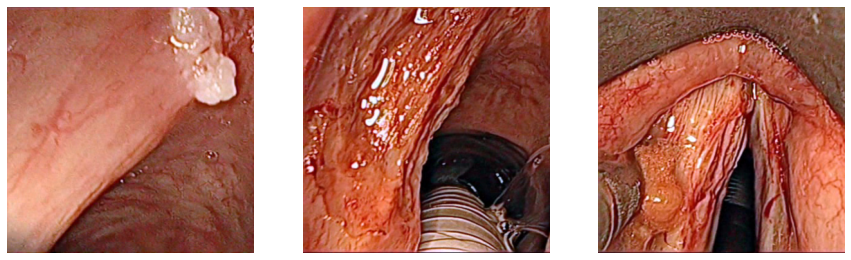

In [ ]:
# Show 3 images samples from created dataset
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
for i, image in enumerate(dataset.take(3)):
    axs[i].imshow(image.numpy() / 255.0)
    axs[i].axis('off')

Dataset split

In [ ]:
#splitting dataset
#training 80%
#test 20%
# take size of total dataset and split test dataset images count 
dataset_size = cardinality(dataset).numpy()
TEST_DS_SIZE = int(dataset_size * 0.20) # 20% of total dataset for test

# take images for test dataset from original dataset (dataset split)
test_dataset = dataset.take(TEST_DS_SIZE)
# let remaining images on loaded dataset
train_dataset = dataset.skip(TEST_DS_SIZE)

TRAIN_DS_SIZE = cardinality(train_dataset).numpy()
TEST_DS_SIZE = cardinality(test_dataset).numpy()

print(f'Training: {TRAIN_DS_SIZE}')
print(f'Test: {TEST_DS_SIZE}')

Training: 376
Test: 94


### **Make data augmentation**



In [ ]:
# make dirs recursively needed for data augmentation 
os.makedirs(LOCAL_DATA_DIR, exist_ok=True)
os.makedirs(LOCAL_AUGMENTED_DATASET_OUTPUT_DIR, exist_ok=True)

In [ ]:
if DO_DATA_AUGMENTATION_OFFLINE:
    if len(os.listdir(LOCAL_AUGMENTED_DATASET_OUTPUT_DIR)) == 0:
        """
        if data augmentation is needed then create a ImageDataGenerator object
        to make moddifications over downloaded images
        Modifications: Horizontal Flip, vertical Flip, Brigghtness range
        between 0.2 and 1 and zoom_range between 0.85 and 1.0
        """
        augmented_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            horizontal_flip=True,
            # vertical_flip=True,
            brightness_range=[0.2, 1], #brightness_range=[0.1, 1],
            rotation_range=5,
            fill_mode='nearest',
            zoom_range=[0.85, 1.0],
            shear_range=0.2,
        )
        # Takes the path to a directory & generates batches of augmented images
        # save each one to augmentation directory and returns a DirectoryIterator
        augmented_generator = augmented_datagen.flow_from_directory(
            LOCAL_DATA_DIR, 
            save_to_dir=LOCAL_AUGMENTED_DATASET_OUTPUT_DIR, 
            shuffle=True, 
            target_size = (IMG_HEIGHT, IMG_WIDTH),
            save_format='png',
            save_prefix='augmented',
            seed=SEED
            )

        # take number of batches
        print(f'Original samples to augment: {augmented_generator.samples}')
        aug_batch_num = int(augmented_generator.samples/augmented_generator.batch_size)
        
        # iterate over DirectoryIterator to augment images on batches
        for _ in tqdm(range(aug_batch_num * DATA_AUGMENTATION_FACTOR)):
            augmented_generator.next()

        # list images in augmented dataset directory an load each one in augmented_dataset  
        print (f'original train dataset: {cardinality(train_dataset).numpy()}')
        augmented_dataset = tf.data.Dataset.list_files(
            LOCAL_AUGMENTED_DATASET_OUTPUT_DIR + '*').map(
                load_image, num_parallel_calls=tf.data.AUTOTUNE)
        print (f'augmented dataset: {cardinality(augmented_dataset).numpy()}')

        # take 1000 augmented images and concatenate them to original train dataset
        train_dataset = train_dataset.concatenate(augmented_dataset)

        print(f'train dataset + data augmentation: {cardinality(train_dataset).numpy()}')
    else:
        print(f"There are files on {LOCAL_AUGMENTED_DATASET_OUTPUT_DIR} directory, seems like previous augmentation was done.")
        print("The augmentation has been skipped. If you whant force augmentation redo please clean directory contents")

Delete local augmented images folder

In [ ]:
# !rm -R {LOCAL_AUGMENTED_DATASET_OUTPUT_DIR}

### **Preprocess dataset**

In [ ]:
def resize(image, width, height):
    """Resize image to specific size"""
    image = tf.image.resize(image, 
                            [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image    

In [ ]:
def normalize(image):
    """Normalizing the images to [-1, 1]"""
    image_normalized = tf.cast(image, tf.float32)
    image_normalized = (image_normalized / 127.5) - 1
    
    return image_normalized

In [ ]:
def preprocess_image_train(image):
    """resize and normalize images"""
    image = resize(image, IMG_WIDTH, IMG_HEIGHT)
    image = normalize(image)
    
    return image

In [ ]:
# preprocess (resize and normalize) each image in dataset
train_dataset = train_dataset.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)

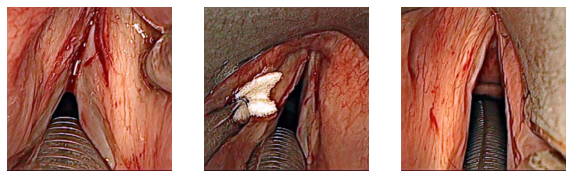

In [ ]:
# plots some dataset examples
fig, axs = plt.subplots(1, 3, figsize=(10, 15))
for i, image in enumerate(train_dataset.take(3)):
    axs[i].imshow((image.numpy() * 0.5 + 0.5).astype(float))
    axs[i].axis('off')

Configure dataset for better performance

In [ ]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# configure datasets for performance
train_dataset = configure_for_performance(train_dataset)
test_dataset = configure_for_performance(test_dataset)

In [ ]:
if DO_DATA_AUGMENTATION_OFFLINE:
  # Count augmented images
  !ls {LOCAL_AUGMENTED_DATASET_OUTPUT_DIR} | wc -l

Prepare splited datasets images in directories for data augmentation on the fly usage

In [ ]:
if DO_DATA_AUGMENTATION_ON_THE_FLY:
  # create folder with training images
  !rm -f {PREPROCESSED_TRAIN_IMAGES_DIR}/img/*.*
  batch = 0
  for images in train_dataset:
    batch = batch + 1
    # denormalize images
    denorm_images = images * 0.5 + 0.5

    for i in range(len(denorm_images)):    
      img = keras.preprocessing.image.array_to_img(denorm_images[i])
      img.save(f"{PREPROCESSED_TRAIN_IMAGES_DIR}/img/train_img_{batch}_{i}.png")

  # create folder with test images
  !rm -f {PREPROCESSED_TEST_IMAGES_DIR}/img/*.*
  batch = 0
  for images in test_dataset:
    batch = batch + 1
    # denormalize images
    denorm_images = images * 0.5 + 0.5
    
    for i in range(len(denorm_images)):
      img = keras.preprocessing.image.array_to_img(denorm_images[i])
      img.save(f"{PREPROCESSED_TEST_IMAGES_DIR}/img/test_img_{batch}_{i}.png")

# **Blocks**

Upsampling block (Deconvolutional)

In [ ]:
def upsample_block(filters, 
                   kernel_size, 
                   strides, 
                   padding='valid', 
                   batch_normalization=True, 
                   activation=tf.keras.layers.ReLU(),
                   kernel_regularizer=None,
                   dropout=None):
    """upsampling block (Deconvolutional)"""    
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    # declare Sequential model
    model = tf.keras.Sequential()    
    # add 2D deconvolutional layer to model
    model.add(
        tf.keras.layers.Conv2DTranspose(filters, 
                                        kernel_size, 
                                        strides=strides,
                                        padding=padding,
                                        kernel_initializer=initializer,
                                        use_bias=False,
                                        kernel_regularizer=kernel_regularizer))
    
    if batch_normalization:
        # add batch normalization layer to model if True
        model.add(tf.keras.layers.BatchNormalization(
            gamma_initializer=initializer,
            scale=False))                   
    # add activation layer to model
    model.add(tf.keras.layers.Activation(activation))

    if dropout is not None:
      # add dropout layer to model if given
      model.add(dropout)
    
    return model

Downsampling block (Convolutional)

In [ ]:
def downsample_block(
    filters, 
    kernel_size, 
    strides, 
    padding='valid', 
    batch_normalization=True, 
    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
    kernel_regularizer=None,
    dropout=None
    ):
    """Downsampling block (Convolutional) """    
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    # declare Sequiential model
    model = tf.keras.Sequential()
    # add 2D convolutional layer to model
    model.add(
        tf.keras.layers.Conv2D(filters, 
                               kernel_size, 
                               strides=strides,
                               padding=padding,
                               kernel_initializer=initializer,
                               use_bias=False,
                               kernel_regularizer=kernel_regularizer))
    
    if (batch_normalization):
        # add batch normalization layer to model if True
        model.add(tf.keras.layers.BatchNormalization(gamma_initializer=initializer,
                                                     scale=False))
    # add activation layer to model
    model.add(tf.keras.layers.Activation(activation))

    if dropout is not None:
      # add dropout layer to model if given
      model.add(dropout)
                   
    return model

# **Generator**

Construct and return Generator model

In [ ]:
def make_generator_model():
    """Construct and return Generator model"""
    # input from latent space
    inputs = tf.keras.Input(shape=(LATENT_SPACE_DIM,))
    # activation for each upsample block on generator model
    activation = tf.keras.layers.ReLU()
    kernel_regularizer = tf.keras.regularizers.l2(l2=0.001)
    
    # stack of upsample blocks
    upsample_stack = [
        #BatchNormalization and Activation='relu' are take by default
        upsample_block(filters=512, kernel_size=5, strides=1, padding='same', activation=activation, kernel_regularizer=kernel_regularizer),
        upsample_block(filters=256, kernel_size=5, strides=2, padding='same', activation=activation, kernel_regularizer=kernel_regularizer),
        upsample_block(filters=128, kernel_size=5, strides=2, padding='same', activation=activation, kernel_regularizer=kernel_regularizer),
        upsample_block(filters=64, kernel_size=5, strides=2, padding='same', activation=activation, kernel_regularizer=kernel_regularizer),
        upsample_block(filters=32, kernel_size=5, strides=2, padding='same', activation=activation, kernel_regularizer=kernel_regularizer),
    ]
    
    x = inputs
    x = tf.keras.layers.Dense(16*16*512)(x)
    x = tf.keras.layers.Reshape((16, 16, 512))(x)

    for up in upsample_stack:
        x = up(x)
        
    # add deconv layer to stack
    x = tf.keras.layers.Conv2DTranspose(
        filters=3,
        kernel_size=5,
        strides=1,
        padding='same',
        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02),
        kernel_regularizer=kernel_regularizer
    )(x)
    # activation for last layer in generator model
    x = tf.keras.layers.Activation('tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name='generator')

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 131072)            13238272  
                                                                 
 reshape (Reshape)           (None, 16, 16, 512)       0         
                                                                 
 sequential (Sequential)     (None, 16, 16, 512)       6555136   
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 256)       3277568   
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 128)       819584    
                                                                 
 sequential_3 (Sequential)   (None, 128, 128, 64)      20

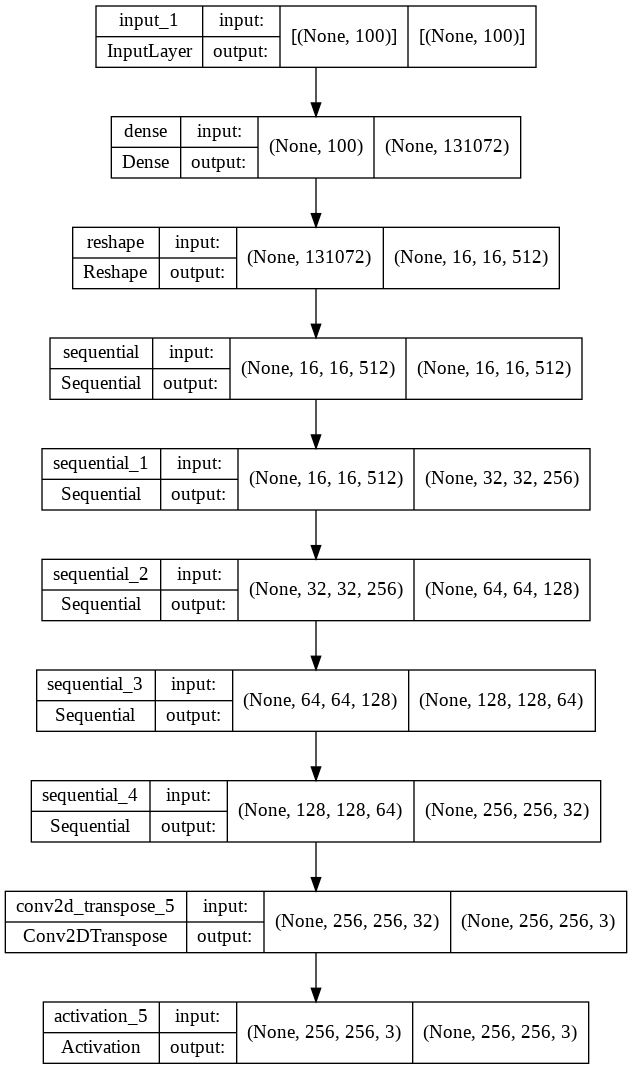

In [ ]:
# instance of Generator model
generator = make_generator_model()
# shows model arch
generator.summary()
# plot and save to file model graph 
tf.keras.utils.plot_model(generator, to_file=MODEL_DIR + '/' + generator.name + '.png', show_shapes=True, show_dtype=False, show_layer_names=True)

(1, 256, 256, 3)


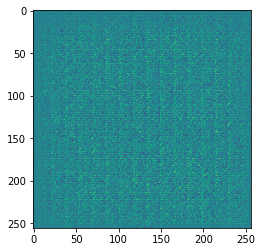

In [ ]:
# test generate sample from noise with untrained generator
noise = tf.random.normal([1, LATENT_SPACE_DIM])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

# **Discriminator**

In [ ]:
def make_discriminator_model(name='discriminator'):
    """Construct and return Discriminator model"""
    # input is generated image from generator model or real image
    inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS))
    activation = tf.keras.layers.LeakyReLU(alpha=0.2)
    kernel_regularizer = tf.keras.regularizers.l2(l2=0.001)
    dropout=tf.keras.layers.Dropout(rate=0.3)

    conv_stack = [
        #Activation=LeakyReLU(0.2) is default, First layer does not have batch normalization
        downsample_block(filters=64,  kernel_size=5, strides=2, padding='same', batch_normalization=False, kernel_regularizer=kernel_regularizer, dropout=dropout),
        downsample_block(filters=128,  kernel_size=5, strides=2, padding='same', batch_normalization=True, kernel_regularizer=kernel_regularizer, dropout=dropout),
        downsample_block(filters=256,  kernel_size=5, strides=2, padding='same', batch_normalization=True, kernel_regularizer=kernel_regularizer, dropout=dropout),
        downsample_block(filters=512,  kernel_size=5, strides=2, padding='same', batch_normalization=True, kernel_regularizer=kernel_regularizer, dropout=dropout),
    ]

    x = inputs

    for conv in conv_stack:
        x = conv(x)

    # add conv layer to stack
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    # activation for last layer in generator model
    x = tf.keras.layers.Activation('sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name='discriminator')


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 128, 128, 64)      4800      
                                                                 
 sequential_6 (Sequential)   (None, 64, 64, 128)       205184    
                                                                 
 sequential_7 (Sequential)   (None, 32, 32, 256)       819968    
                                                                 
 sequential_8 (Sequential)   (None, 16, 16, 512)       3278336   
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 1)               

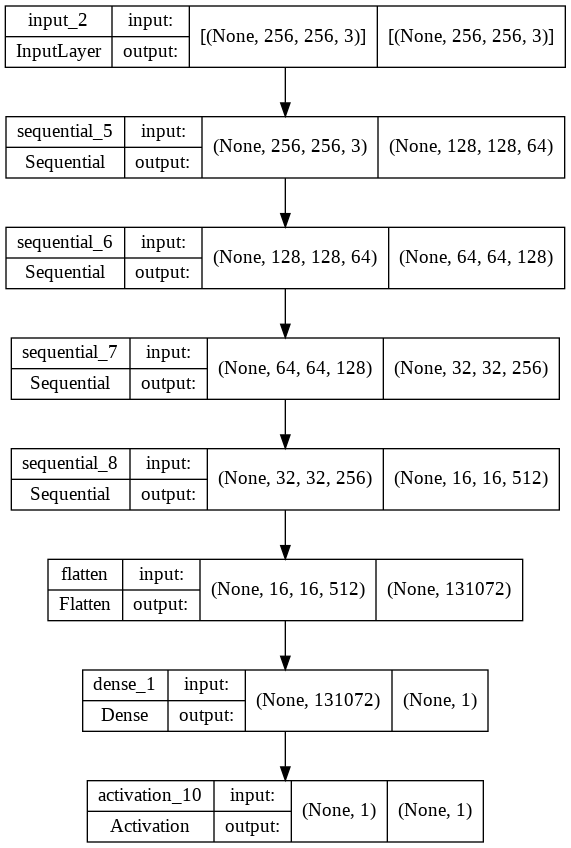

In [ ]:
# instance of Discriminator model
discriminator = make_discriminator_model()
# show model arch
discriminator.summary()
# plot and save to file model graph 
tf.keras.utils.plot_model(discriminator, to_file=MODEL_DIR + '/' + discriminator.name + '.png', show_shapes=True)

In [ ]:
# test discriminator decision and check output shape
discriminator = make_discriminator_model()
decision = discriminator(generated_image, training=False)
print(generated_image.shape)
print (decision[0][0].numpy())

(1, 256, 256, 3)
0.500027


# **Loss**

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Discriminator Loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Generator Loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# **Metrics**

#### **FID**

Calculate Frechet Inception Distance (FID) with Keras InceptionV3 model

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

inceptionv3_model = InceptionV3(include_top=False, pooling='avg',
                    input_shape=(IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS))

# calculate frechet inception distance
def calculate_fid(images1, images2):
    model = inceptionv3_model
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
      covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87924736/87910968 [==============================] - 1s 0us/step


### **Plot methods**

Plot and save metrics and losses history

In [ ]:
from matplotlib import pyplot
import os

# save plot train history
def plot_train_loss_history(d_hist, g_hist, x_labels_list=None, 
                            filename=PLOTS_DIR +'/plot_train_loss.png', 
                            grid=True, show=False):
    """creates a line plot of loss for the gan and save to file"""
    pyplot.subplot(1, 1, 1)
    pyplot.ylabel('Loss')
    pyplot.xlabel('Epoch number')
    pyplot.title('Training loss metrics')
    if x_labels_list and len(x_labels_list) <= 20:
        pyplot.xticks(range(len(x_labels_list)), x_labels_list, rotation='horizontal')
    pyplot.plot(d_hist, label='train d_loss')
    pyplot.plot(g_hist, label='train g_loss')
    pyplot.grid() if grid else None
    pyplot.legend()
    pyplot.savefig(filename)
    pyplot.show() if show else None
    pyplot.close()

# save plot with test loss
def plot_loss_metrics(d_hist, g_hist, d_label='test d_loss', g_label='test g_loss',
                      x_labels_list=None, filename='./test_loss.png',
                      grid=True, show=False):
    # plot loss
    pyplot.subplot(1, 1, 1)
    pyplot.ylabel('Loss')
    pyplot.xlabel('Epoch number')
    pyplot.title('Test Loss metrics')
   
    if x_labels_list and len(x_labels_list) <= 20:
        pyplot.xticks(x_labels_list, rotation='horizontal')

    pyplot.plot(x_labels_list, d_hist, label=d_label)
    pyplot.plot(x_labels_list, g_hist, label=g_label)
    pyplot.legend()    
    pyplot.grid() if grid else None 
    pyplot.savefig(filename)
    pyplot.show() if show else None
    pyplot.close()
    
# save plot with FID metrics       
def plot_fid_metrics(fid_test_hist, fid_train_hist, fid_test_label='test fid', 
                     fid_train_label='training fid', x_labels_list=None,
                     filename='./plot_fid.png'):
    # plot loss
    pyplot.subplot(1, 1, 1)
    pyplot.ylabel('FID')
    pyplot.xlabel('Epoch number')
    pyplot.title('Test FID metrics')
    if x_labels_list and len(x_labels_list) <= 25:
        pyplot.xticks(range(len(x_labels_list)), x_labels_list, rotation='horizontal')
    pyplot.plot(fid_test_hist, label=fid_test_label)
    pyplot.plot(fid_train_hist, label=fid_train_label)
    pyplot.legend()
    # save plot to file
    pyplot.savefig(filename)
    pyplot.close()

# save plot with metrics (Generic)
def plot_metric_history(metric_hist, 
                        metric_legend_label=None,
                        y_label='Metric',
                        x_label='Epoch number',
                        plot_title='Metric title', 
                        x_labels_list=None, filename='./plot_metric.png',
                        grid=True,
                        show=False):  
    # plot loss
    pyplot.subplot(1, 1, 1)
    pyplot.ylabel(y_label)
    pyplot.xlabel(x_label)
    pyplot.title(plot_title)
    
    if x_labels_list and len(x_labels_list) <= 20:
        pyplot.xticks(x_labels_list, rotation='horizontal')      
    
    if metric_legend_label:
        pyplot.plot(x_labels_list, metric_hist, label=metric_legend_label)
        pyplot.legend()
    else:
        pyplot.plot(x_labels_list, metric_hist)
    
    pyplot.grid() if grid else None
    pyplot.savefig(filename)
    pyplot.show() if show else None
    pyplot.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_test_metrics_history(fid_hist, x_labels_list,
                                    fid_label='test FID', 
                                    # auc_label='test auc', 
                                    filename='./plot_bests_test_metrics.png',
                                    save_bests=5):
    
    # print(f"Epochs: {x_labels_list}")
    # print(f"Dice: {dice_coef_hist}")
    # print(f"AUC: {auc_hist}")

    x = np.arange(len(x_labels_list))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, fid_hist, width, label=fid_label, color="green")
    # rects2 = ax.bar(x + width/2, auc_hist, width, label=auc_label)

    # Add some text for labels, title and custom axis tick labels, etc.
    ax.set_ylabel('FID value')
    ax.set_xlabel('Epoch number')
    ax.set_title('Bests FID for test dataset')
    ax.set_xticks(x)
    plt.grid(axis='y', alpha=.4)
    ax.set_yticks([15, 25, 31, 33])
    ax.set_xticklabels(x_labels_list)
    ax.legend(loc='lower right')
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

Utility method to plot save metrics or losses history from .csv history file

In [ ]:
import pandas
def plot_metrics_from_csv_history(test_history_file=PLOTS_DIR+'/metrics_history.csv', 
                                  plot_filename='metric.png'):
    """
    Util method to plot metric history from .csv file
    """
    metrics_hist = []
    # last_epoch = 0
    if os.path.isfile(test_history_file):
        dataframe = pandas.read_csv(test_history_file)
        metrics_hist = dataframe.to_dict('records')

        epochs_list = [item_dict['epoch'] for item_dict in metrics_hist]

        # plot test loss to file
        # plot_loss_metrics(
        #     d_hist=[item_dict['test_d_loss'] for item_dict in metrics_hist], 
        #     g_hist=[item_dict['test_g_loss'] for item_dict in metrics_hist], 
        #     d_label='test d_loss', g_label='test g_loss', x_labels_list=epochs_list,
        #     filename=PLOTS_DIR + '/TEST_loss_test_dataset.png')
        
        plot_train_loss_history(
            d_hist = [item_dict['d_loss'] for item_dict in metrics_hist], 
            g_hist = [item_dict['g_loss'] for item_dict in metrics_hist],
            x_labels_list = epochs_list,
            filename=PLOTS_DIR +'/TEST_plot_train_loss.png') 
    else:
        print(f"File {test_history_file} does not exists")

In [ ]:
# find n epochs with better FID metrics from .csv test history files
import pandas

def plot_best_fid_from_csv_history(test_history_file=PLOTS_DIR+'/metrics_history.csv', 
                                   plot_results=False, 
                                   plot_filename='bests_fid_test_ds_metrics.png',
                                   save_bests=5):
    """
    Util method to find and plot n epochs with better FID metrics 
    from .csv test history files
    """
    metrics_hist = []
    # last_epoch = 0
    if os.path.isfile(test_history_file):
        dataframe = pandas.read_csv(test_history_file)
        metrics_hist = dataframe.to_dict('records')

        # sort metrics list by test_fid and get bests save_bests metrics with higher g_mean 
        bests_metrics = sorted(metrics_hist, key = lambda i: (i['test_fid']))[:save_bests]
        # sort by epoch number
        bests_metrics = sorted(bests_metrics, key = lambda i: (i['epoch']))

        # if plot_results:
        # plot_test_metrics_history()
        test_fid_list = list()
        epochs_number_list = list()

        for metric in bests_metrics:
            test_fid_list.append(metric['test_fid'])
            epochs_number_list.append(metric['epoch'])

            print(f"epoch: {metric['epoch']} - test_fid: {metric['test_fid']}\n")

        # plot results
        # plot_test_metrics_history(dice_coef_hist=mean_dice_coef_list,
        #                                 auc_hist=mean_auc_list,
        #                                 x_labels_list=epochs_number_list,
        #                                 dice_coef_label='test Dice Coefficient',
        #                                 auc_label='test AUC',
        #                                 filename=plot_filename)
        if plot_results:
            plot_test_metrics_history(fid_hist=test_fid_list, 
                                            x_labels_list=epochs_number_list,
                                            fid_label='test FID', 
                                            filename=plot_filename,
                                            save_bests=save_bests)
        
            print(f"\nResults has been saved to: {plot_filename}")

        # plot_train_loss_history(
        #     test_fid_hist = [item_dict['test_fid'] for item_dict in metrics_hist],
        #     x_labels_list = epochs_list,
        #     filename=PLOTS_DIR +'/TEST_plot_train_loss.png') 
    else:
        print(f"File {test_history_file} does not exists")

In [ ]:
plot_best_fid_from_csv_history(test_history_file=PLOTS_DIR+'/metrics_history.csv', 
                              plot_results=True, 
                              plot_filename=PLOTS_DIR+'/bests_fid_test_ds_metrics.png',
                              save_bests=5)

epoch: 1450 - test_fid: 26.694902420043945

epoch: 1550 - test_fid: 28.04195213317871

epoch: 2350 - test_fid: 28.77195930480957

epoch: 2750 - test_fid: 28.220298767089844

epoch: 3050 - test_fid: 27.14243125915528

epoch: 3200 - test_fid: 28.666015625

epoch: 3250 - test_fid: 29.024965286254883

epoch: 3700 - test_fid: 28.638710021972656

epoch: 4250 - test_fid: 28.74546241760254

epoch: 4300 - test_fid: 29.01824951171875

epoch: 4450 - test_fid: 27.77118492126465

epoch: 4850 - test_fid: 27.73559188842773

epoch: 5250 - test_fid: 28.91905975341797

epoch: 5750 - test_fid: 27.79965591430664

epoch: 5950 - test_fid: 27.014617919921875

epoch: 7150 - test_fid: 29.010461807250977

epoch: 7450 - test_fid: 28.536592483520508

epoch: 7750 - test_fid: 28.078264236450195

epoch: 8150 - test_fid: 29.006223678588867

epoch: 8250 - test_fid: 28.658342361450195



In [ ]:
# # plot matrics from history.csv file
# plot_metrics_from_csv_history(PLOTS_DIR+'/metrics_history.csv')
# plot_metrics_from_csv_history(PLOTS_DIR+'/train_history.csv')

# **Callbacks**

### **MetricsMonitor callback**

MetricsMonitor callback class implementation

In [ ]:
import pandas
from tensorflow.python.ops.numpy_ops import np_config

class MetricsMonitor(tf.keras.callbacks.Callback):
    """
    Callback that periodically saves generated images, calc loss and fid
    and save ploted graphics to file during test step
    """
    def __init__(self, latent_dim, test_dataset=None, train_dataset=None,
                 metrics_freq=1, metrics_start_epoch=1, save_metrics_gen_imgs=True):
        self.latent_dim = latent_dim
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.metrics_freq = metrics_freq
        self.metrics_start_epoch = metrics_start_epoch
        self.save_metrics_gen_imgs = save_metrics_gen_imgs
        # metrics
        self.test_d_loss_metric = keras.metrics.Mean(name="test_d_loss")
        self.test_g_loss_metric = keras.metrics.Mean(name="test_g_loss")
        self.test_fid_metric = keras.metrics.Mean(name="test_fid")
        self.train_fid_metric = keras.metrics.Mean(name="train_fid")
        # keys
        self.keys = ['epoch', 'test_d_loss', 'test_g_loss', 'test_fid', 'train_fid']
        """self.test_metrics_hist =  [{'epoch': 1, 'test_d_loss': 0.0, 'test_g_loss': 0.0, 
                                      'test_fid': 0.0, 'train_fid': 0.0,}, """
        self.metrics_hist = []  
        self.metrics_history_file = PLOTS_DIR + '/metrics_history.csv'


    def scale_images(self, images, new_shape=(299,299,3)):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = skimage.transform.resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)

    def load_metrics_history(self):
        last_epoch = 0
        if os.path.isfile(self.metrics_history_file):
            dataframe = pandas.read_csv(self.metrics_history_file)
            self.metrics_hist = dataframe.to_dict('records')
            # last_epoch = len(self.metrics_hist)
            last_epoch = int(self.metrics_hist[len(self.metrics_hist) - 1]['epoch'])

        return last_epoch

    def on_train_begin(self, epoch, logs=None):
        # load and make backup of existing train_history.csv file
        if os.path.isfile(self.metrics_history_file):
            date_time_str = datetime.now().strftime("%Y%m%d-%H%M%S")
            shutil.copy2(self.metrics_history_file,
                         self.metrics_history_file + f".{date_time_str}-E{self.load_metrics_history()}.bak.csv")
        else:
            # just make backup
            self.load_metrics_history()

    def on_epoch_begin(self, epoch, logs=None):
        # load history from csv file
        if epoch == 0:
            self.metrics_hist = [] 
        # else if last registered epoch is heigher than current epoch
        elif len(self.metrics_hist) > 0 and int(self.metrics_hist[len(self.metrics_hist) - 1]['epoch']) > epoch:
            # store heigher epoch index
            heigher_epoch_idx = len(self.metrics_hist) - 1
            # split array until  just before the heiger epoch index
            self.metrics_hist = self.metrics_hist[:heigher_epoch_idx]

    def on_epoch_end(self, epoch, logs=None):
        # reset metrics
        self.test_d_loss_metric.reset_state()
        self.test_g_loss_metric.reset_state()
        self.test_fid_metric.reset_state()
        self.train_fid_metric.reset_state()
                     
        # if (epoch + 1) % self.metrics_freq == 0 and (epoch + 1) % self.metrics_start_epoch == 0:
        if (epoch + 1) >= self.metrics_start_epoch and (epoch + 1) % self.metrics_freq == 0:
            # np_config.enable_numpy_behavior()
            #### test (calc with test dataset) ####
            test_fid = train_fid = 0.0
            mean_test_fid = mean_train_fid = 0.0
            # initialize metrics dictionary
            metrics_dict = {'epoch': epoch + 1, 
                            'test_d_loss': 0.0, 
                            'test_g_loss': 0.0, 
                            'test_fid': 0.0, 
                            'train_fid': 0.0,
                            }
            # auxialiar arrays
            generated_images = []
            testing_images = []

            if self.test_dataset:
                print("\nCalculating FID with test dataset...")
                test_generated_images = []
                for test_images in tqdm(self.test_dataset):
                    batch_size = tf.shape(test_images)[0]

                    # loss (generate samples and evaluate model)
                    # get noise
                    noise = tf.random.normal(shape=(batch_size, self.latent_dim))
                    # generate sample from noise
                    fake_images = self.model.generator(noise, training=False)
                    # results of dicrimination
                    real_output = self.model.discriminator(test_images, training=False)
                    fake_output = self.model.discriminator(fake_images, training=False)

                    # calc loss of discriminator and gnerator
                    test_g_loss = self.model.train_g_loss_fn(fake_output)
                    test_d_loss = self.model.train_d_loss_fn(real_output, fake_output)

                    # Update loss metrics
                    self.test_d_loss_metric.update_state(test_d_loss)
                    self.test_g_loss_metric.update_state(test_g_loss)              
                    
                    # # normalized_images = fake_images * 0.5 + 0.5
                    # fake_images = fake_images * 0.5 + 0.5
                    # test_images = test_images * 0.5 + 0.5

                    for fake_img in fake_images:
                        generated_images.append(fake_img)
                    
                    for test_img in test_images:
                        testing_images.append(test_img) 

                # denormalize and store generated images for future save to files
                test_generated_images = asarray(generated_images) * 0.5 + 0.5

                # Preprocess images before pass then to inception_v3
                # model for FID calculations 
                # fake images        
                generated_images = asarray(generated_images).astype('float32')
                generated_images = keras.applications.inception_v3.preprocess_input(generated_images)                   
                # test images
                testing_images = asarray(testing_images).astype('float32')              
                testing_images = keras.applications.inception_v3.preprocess_input(testing_images)
                # FID (calc fid with generated and test dataset images and sum to global)
                test_fid = calculate_fid(testing_images, generated_images)
                self.test_fid_metric.update_state(test_fid)            
                
                # calc FID and losess mean for test dataset
                mean_test_fid = self.test_fid_metric.result()
                mean_test_g_loss = self.test_g_loss_metric.result()
                mean_test_d_loss = self.test_d_loss_metric.result()

                # write to tensorboard
                with metrics_file_writer.as_default():
                    # Losses
                    tf.summary.scalar('test_d_loss', mean_test_d_loss, step=epoch)
                    tf.summary.scalar('test_g_loss', mean_test_g_loss, step=epoch)                    
                    tf.summary.scalar('test_fid', mean_test_fid, step=epoch)

            
            generated_images = []
            training_images = []
            
            if self.train_dataset:
                print("Calculating FID with training dataset...")
                for train_images in tqdm(self.train_dataset):
                    batch_size = tf.shape(train_images)[0]
                    ### metrics (generate samples and evaluate model) ###
                    # get noise
                    noise = tf.random.normal(shape=(batch_size, self.latent_dim))
                    # generate sample from noise
                    fake_images = self.model.generator(noise, training=False)
                    # denormalize images
                    # fake_images = fake_images * 0.5 + 0.5
                    # train_images = train_images * 0.5 + 0.5

                    for fake_img in fake_images:
                        generated_images.append(fake_img)
                    
                    for train_img in train_images:
                        training_images.append(train_img) 

                # convert ti float images elements and preprocess them before pass then 
                # to the inception_v3 model
                generated_images = asarray(generated_images).astype('float32')            
                generated_images = keras.applications.inception_v3.preprocess_input(generated_images)
                # train images
                training_images = asarray(training_images).astype('float32')               
                training_images = keras.applications.inception_v3.preprocess_input(training_images)

                # FID (calc fid with generated and train dataset images and sum to global)
                train_fid = calculate_fid(generated_images, training_images)
                # update metric
                self.train_fid_metric.update_state(train_fid)

                # calc mean FID
                mean_train_fid = self.train_fid_metric.result()

                # write to tensorboard
                with metrics_file_writer.as_default():
                    tf.summary.scalar('train_fid', mean_train_fid, step=epoch)  
                            
                            
            # store on metrics dict
            metrics_dict['epoch'] = epoch + 1
            metrics_dict['test_g_loss'] = float(mean_test_g_loss)
            metrics_dict['test_d_loss'] = float(mean_test_d_loss)
            metrics_dict['test_fid'] = float(mean_test_fid)
            metrics_dict['train_fid'] = float(mean_train_fid)
            # add metrics dict to historical list
            self.metrics_hist.append(metrics_dict)

            # Build epochs numbers list
            epochs_list = [item_dict['epoch'] for item_dict in self.metrics_hist]

            if self.train_dataset:
                # plot metrics dice_coef train dataset
                plot_metric_history(
                    metric_hist=[round(item_dict['train_fid'], 3) for item_dict in self.metrics_hist],
                    y_label='FID',
                    x_label='Epoch number',
                    plot_title='Train dataset FID metrics',
                    x_labels_list=epochs_list,
                    filename=PLOTS_DIR+'/train_ds_FID_metrics.png')
            
            
            if self.test_dataset:
                # plot test loss to file
                plot_loss_metrics(
                    d_hist=[item_dict['test_d_loss'] for item_dict in self.metrics_hist], 
                    g_hist=[item_dict['test_g_loss'] for item_dict in self.metrics_hist], 
                    d_label='test d_loss', g_label='test g_loss', x_labels_list=epochs_list,
                    filename=PLOTS_DIR + '/loss_test_dataset.png')

                # Save test generated image
                if self.save_metrics_gen_imgs:
                    for i in range(len(test_generated_images)):
                        img = keras.preprocessing.image.array_to_img(test_generated_images[i])
                        img.save(DRIVE_TEST_GENERATED_IMAGES_DIR + '/test_gen_img_%03d_%d.png' % ((epoch + 1), i))

                # plot metrics dice_coef test dataset
                plot_metric_history(
                    metric_hist=[round(item_dict['test_fid'], 3) for item_dict in self.metrics_hist],
                    y_label='FID',
                    x_label='Epoch number',
                    plot_title='Test dataset FID metrics',
                    x_labels_list=epochs_list,
                    filename=PLOTS_DIR+'/test_ds_FID_metrics.png')
 

            # remove tmp file
            if os.path.isfile(self.metrics_history_file+"_tmp"):
                    os.remove(self.metrics_history_file+"_tmp")

            # write changes to file
            with open(self.metrics_history_file+"_tmp", 'w', 
                      encoding='utf8', newline='') as f:
                y = csv.DictWriter(f, fieldnames=self.keys)
                y.writeheader()
                y.writerows(self.metrics_hist)
                f.flush() # flushes the file internals buffers for clean close
            
            if os.path.isfile(self.metrics_history_file+"_tmp"):
                # remove regular file if exists
                if os.path.isfile(self.metrics_history_file):
                    os.remove(self.metrics_history_file)
                # rename tmp file to regular file
                if not os.path.isfile(self.metrics_history_file):
                    os.rename(self.metrics_history_file+"_tmp", self.metrics_history_file)


            print(f'train_fid: {mean_train_fid:.4f} - test_fid: {mean_test_fid:.4f}')

In [ ]:
# create instance of MetricsMonitor callback
metrics_monitor_callback = MetricsMonitor(latent_dim=LATENT_SPACE_DIM, 
                                          test_dataset=test_dataset,
                                          train_dataset=train_dataset, 
                                          metrics_freq=METRICS_FREQ, 
                                          metrics_start_epoch=METRICS_START_EPOCH,
                                          save_metrics_gen_imgs=True)

### **Monitor callback**

Training Monitor callback class implementation

In [ ]:
import pandas
from keras.utils.io_utils import path_to_string
import collections
import csv

class GANMonitor(tf.keras.callbacks.Callback):
    """
    A callback that periodically saves generated images and plot loss
    graph during training
    """
    def __init__(self, latent_dim, num_img=5):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.keys = None
        self.train_logs_hist = [] # [{'epoch': 1, 'd_loss': 1.18, 'g_loss': 1.98}, ...]
        self.train_history_file = PLOTS_DIR+'/train_history.csv'

    def load_train_history(self):
        loaded_epochs = 0
        if os.path.isfile(self.train_history_file):
            dataframe = pandas.read_csv(self.train_history_file)
            self.train_logs_hist = dataframe.to_dict('records')
            loaded_epochs = len(self.train_logs_hist)

        return loaded_epochs                  

    def on_train_begin(self, epoch, logs=None):        
        # load and make backup of existing train_history.csv file
        if os.path.isfile(self.train_history_file):
            date_time_str = datetime.now().strftime("%Y%m%d-%H%M%S")
            shutil.copy2(self.train_history_file, self.train_history_file+f".{date_time_str}-E{self.load_train_history()}.bak.csv")
        else: 
            # just make backup
            self.load_train_history()
        

    # get metrics hists from model
    def on_epoch_begin(self, epoch, logs=None):

        if epoch == 0:
            self.train_logs_hist = [] 
        elif len(self.train_logs_hist) > epoch:
            self.train_logs_hist = self.train_logs_hist[:epoch]

    def on_epoch_end(self, epoch, logs=None):

        def handle_value(k):
            is_zero_dim_ndarray = isinstance(k, np.ndarray) and k.ndim == 0
            if isinstance(k, str):
                return k
            elif isinstance(k, collections.abc.Iterable) and not is_zero_dim_ndarray:
                return '"[%s]"' % (', '.join(map(str, k)))
            else:
                return k

        if self.keys is None:
            self.keys = ['epoch']
            self.keys += sorted(logs.keys())

        # store current training metrics
        row_dict = {'epoch': epoch + 1}
        row_dict.update((key, handle_value(logs[key])) for key in logs.keys()) 
        self.train_logs_hist.append(row_dict)

        # SAVE PLOT AND HISTORY FILE OF METRICS
        if (epoch + 1) % SAVE_PLOT_TRAIN_INTERVAL == 0:           
            epochs_list = [item_dict['epoch'] for item_dict in self.train_logs_hist]

            # plot train loss results
            plot_train_loss_history(
                d_hist = [item_dict['d_loss'] for item_dict in self.train_logs_hist], 
                g_hist = [item_dict['g_loss'] for item_dict in self.train_logs_hist],
                x_labels_list = epochs_list)    
            
            # remove tmp file
            if os.path.isfile(self.train_history_file+"_tmp"):
                    os.remove(self.train_history_file+"_tmp")

            # write changes to file
            with open(self.train_history_file+"_tmp", 'w', 
                      encoding='utf8', newline='') as f:
                y = csv.DictWriter(f, fieldnames=self.keys)
                y.writeheader()
                y.writerows(self.train_logs_hist)
                f.flush() # flushes the file internal buffer for clean close
      
            if os.path.isfile(self.train_history_file+"_tmp"):
                # remove regular file if exists
                if os.path.isfile(self.train_history_file):
                    os.remove(self.train_history_file)
                # rename tmp file to regular file
                if not os.path.isfile(self.train_history_file):
                    os.rename(self.train_history_file+"_tmp", self.train_history_file)

           
        # SAVE GENERATED IMAGES
        if (epoch + 1) >= SAVE_IMAGES_START and (epoch + 1) % SAVE_IMAGES_INTERVAL == 0:
            # generate latent vectors from latent space
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            # generate images from noise
            generated_images = self.model.generator(random_latent_vectors, training=False)
            # denormalize images            
            generated_images = generated_images * 0.5 + 0.5

            for i in range(len(generated_images)):
                # save generated iamges to files
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(DRIVE_GENERATED_IMAGES_DIR + '/generated_img_%03d_%d.png' % ((epoch + 1), i))


### **CustomTensorBoard callback**

In [ ]:
class CustomTensorBoard(tf.keras.callbacks.Callback):
    """Publish metrics to TensorBoard at the end of each epoch"""

    def __init__(self, file_writer):
        super(CustomTensorBoard, self).__init__()
        self.file_training_writer = file_writer 


    def on_epoch_end(self, epoch, logs=None):
        # logs['test_train_d_loss'] = 10.921
        with self.file_training_writer.as_default():            
            #Losses
            tf.summary.scalar('d_loss', logs['d_loss'], step=epoch)
            tf.summary.scalar('g_loss', logs['g_loss'], step=epoch)

            #metrics
            #tf.summary.scalar('fid', logs['train_fid'], step=epoch)

            #Learning rates
            lr = float(tf.keras.backend.get_value(self.model.g_optimizer.learning_rate))
            tf.summary.scalar('g_lr', lr, step=epoch)

            lr = float(tf.keras.backend.get_value(self.model.d_optimizer.learning_rate))
            tf.summary.scalar('d_lr', lr, step=epoch)
            
          

In [ ]:
# instance of callback
tensorboard_callback = CustomTensorBoard(file_writer=training_file_writer)

### **CustomLearningRateScheduler callback**

In [ ]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    """Learning rate scheduler which start decaying after epoch 100.

    Arguments: schedule (function): takes an epoch index (integer, indexed from 0) and current
              learning rate as inputs and returns a new learning rate as output (float).
              decay_rate (float): factor of dacay learning rate
    """

    def __init__(self, schedule, initial_epoch_decay, initial_learning_rate, optimizer_name = ''):
        super(CustomLearningRateScheduler, self).__init__()
        
        self.schedule = schedule
        self.initial_epoch_decay = initial_epoch_decay
        self.initial_learning_rate = initial_learning_rate
        self.optimizer_name = optimizer_name

    def on_epoch_begin(self, epoch, logs=None):
        
        #After n-epochs start decaying learning rate
        if((epoch + 1) > self.initial_epoch_decay):

            if self.optimizer_name == 'g_optimizer':
                lr = float(tf.keras.backend.get_value(self.model.g_optimizer.learning_rate))
                scheduled_lr = self.schedule(epoch, initial_learning_rate=self.initial_learning_rate)
                # set new lr to generator model
                tf.keras.backend.set_value(self.model.g_optimizer.lr, scheduled_lr)
            
            if self.optimizer_name == 'd_optimizer':
                lr = float(tf.keras.backend.get_value(self.model.d_optimizer.learning_rate))
                scheduled_lr = self.schedule(epoch, initial_learning_rate=self.initial_learning_rate)
                # set new lr to discriminator model
                tf.keras.backend.set_value(self.model.d_optimizer.lr, scheduled_lr)
  

In [ ]:
# Decaying learning rate
# lr_start = 0.0002, lr_end = 0, epoch_decay > 100 
# decay_rate = (0 - 0.0002)/(EPOCHS - 100)

train_data_size = cardinality(train_dataset).numpy()
steps_per_epochs = train_data_size / BATCH_SIZE

# on_epoch_begin manage epochs as zero-based index
def linear_decay_learning_rate(epoch, 
                               initial_learning_rate,
                               final_epoch = EPOCHS - 1, 
                               initial_epoch = lr_decay_initial_epoch - 1, 
                               end_learning_rate = 0):
    """
    Calcs and returns constant and linear decay lr during training. This method is 
    passed to CustomLearningRateScheduler constructor class 
    to calc lr on each callback to the class
    """
    lr = ((initial_learning_rate - end_learning_rate) * 
            (1 - (epoch - initial_epoch) / (final_epoch - initial_epoch)
            )  + end_learning_rate)
    
    return lr

# Linear decay learning rate from {LEARNING_RATE} to zero
d_lr_callback = CustomLearningRateScheduler(linear_decay_learning_rate, initial_epoch_decay=lr_decay_initial_epoch, initial_learning_rate=D_LEARNING_RATE, optimizer_name='d_optimizer')
g_lr_callback = CustomLearningRateScheduler(linear_decay_learning_rate, initial_epoch_decay=lr_decay_initial_epoch, initial_learning_rate=G_LEARNING_RATE, optimizer_name='g_optimizer')

### **CustomCheckpointModel callback**

In [ ]:
class CustomCheckpointModel(tf.keras.callbacks.Callback):
    """Save checkpoint every n-th epochs (epochs are zero-based index)"""

    def __init__(self, filepath, save_epoch_freq, save_epoch_start=0, filename=''):
        super(CustomCheckpointModel, self).__init__()
        self.save_epoch_freq = save_epoch_freq
        self.save_epoch_start = save_epoch_start
        self.filepath = filepath
        self.filename = filename

        self.ckpt = None
        
    def on_epoch_end(self, epoch, logs=None):
       
        if self.ckpt is None:
            self.ckpt = self.ckpt_fn()

        self.ckpt.epoch.assign_add(1)

        if (epoch + 1) >= self.save_epoch_start and (epoch + 1) % self.save_epoch_freq == 0:
            # instantiate a CheckpointManager and save checkpoint to file
            ckpt_manager = tf.train.CheckpointManager(self.ckpt, self.filepath, checkpoint_name =  self.filename + ".{epoch:03}".format(epoch=epoch + 1), max_to_keep=None)
            ckpt_manager.save()
                  
    def ckpt_fn(self):
        return tf.train.Checkpoint(epoch=tf.Variable(0),
                                   generator=self.model.generator,
                                   discriminator=self.model.discriminator,
                                   g_optimizer=self.model.g_optimizer,
                                   d_optimizer=self.model.d_optimizer)


In [ ]:
# Instantiate checkpoint calback to passit to model.fit() method
# in callbacks list
checkpoint_callback = CustomCheckpointModel(
    filepath=CHECKPOINTS_DIR,
    filename='gan_checkpoint',
    save_epoch_freq=SAVE_EPOCH_FREQ,
    save_epoch_start=SAVE_EPOCH_START    
)


# **Model**

### **GAN Model implementation**

In [ ]:
# Gan model and Override train_step
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.discriminator = discriminator 
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, train_d_loss_fn, train_g_loss_fn):
        super(GAN, self).compile()
        # optimizers
        self.d_optimizer = d_optimizer # discriminator optimizer
        self.g_optimizer = g_optimizer # generator optimizer
        # loss functions
        self.train_d_loss_fn = train_d_loss_fn # loss function of discriminatior
        self.train_g_loss_fn = train_g_loss_fn # loss function of generator
        # metrics
        self.train_d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.train_g_loss_metric = keras.metrics.Mean(name="g_loss")

    def train_step(self, real_images):      
        batch_size = tf.shape(real_images)[0]
        # get noise
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            # generate fake images from noise
            fake_images = self.generator(noise, training=True)
            # get real and fake clasifications from discriminator
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            # evaluate discriminator training loss
            disc_loss = self.train_d_loss_fn(real_output, fake_output)
        # update disciminator gradients with calculated loss
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))    
        
        #Train generator
        with tf.GradientTape() as gen_tape:
            # generate fake images from noise
            fake_images = self.generator(noise, training=True)
            # get clasifications from discriminator
            fake_output = self.discriminator(fake_images, training=True)
            # evaluate generator training loss
            gen_loss = self.train_g_loss_fn(fake_output)
        # update generator gradients with calculated loss
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        # Update loss metrics
        self.train_d_loss_metric.update_state(disc_loss)
        self.train_g_loss_metric.update_state(gen_loss)

        return {
            "d_loss": self.train_d_loss_metric.result(),
            "g_loss": self.train_g_loss_metric.result(),
            # "train_d_loss": disc_loss,
            # "train_g_loss": gen_loss
        }

    def call(self, inputs):
        dummy = 'dummy'


### **Instantiate and compile the GAN model**

In [ ]:
# instantiate gan model with previous declared generator and discriminator
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_SPACE_DIM)
# compile model with optimizers and loss functions
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=D_LEARNING_RATE, beta_1=0.5), #antes decia 2e-4,
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=G_LEARNING_RATE, beta_1=0.5),#antes decia 2e-4, 
    train_d_loss_fn=discriminator_loss,
    train_g_loss_fn=generator_loss
)


### **Train GAN model**

In [ ]:
if DO_DATA_AUGMENTATION_ON_THE_FLY:
  """Makes real time augmentation of images batches during training"""
  # create ImageDataGerator with transformations
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                  horizontal_flip=True,
                  # vertical_flip=True,
                  brightness_range=[0.2, 1], #brightness_range=[0.1, 1],
                  rotation_range=5,
                  fill_mode='nearest',
                  zoom_range=[0.85, 1.0],
                  shear_range=0.2,
                  preprocessing_function=normalize # [-1, 1]
                  )
  # instantiate datagenerator to pass it to .fit() method as dataset
  train_generator = train_datagen.flow_from_directory(
      PREPROCESSED_TRAIN_IMAGES_DIR+"/",
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      color_mode="rgb",
      batch_size=BATCH_SIZE,
      shuffle=True,
      seed=SEED,
      class_mode=None)
  # fit the model (train)
  train_history = gan.fit(
      train_generator,
      steps_per_epoch=TRAIN_DS_SIZE / BATCH_SIZE,
      epochs=EPOCHS, 
      callbacks=[ # callbacks list
                  GANMonitor(num_img=SAVE_IMAGES_COUNT, latent_dim=LATENT_SPACE_DIM), 
                  tensorboard_callback,
                  # d_lr_callback,
                  # g_lr_callback,
                  checkpoint_callback,
                  metrics_monitor_callback
                ]
  )
else:
  # tf.config.run_functions_eagerly(True)
  # fit the model (train) with static train dataset
  train_history = gan.fit(
      train_dataset,
      epochs=EPOCHS, 
      callbacks=[ # callbacks list
                  GANMonitor(num_img=SAVE_IMAGES_COUNT, latent_dim=LATENT_SPACE_DIM), 
                  tensorboard_callback,
                  # d_lr_callback,
                  # g_lr_callback,
                  checkpoint_callback,
                  metrics_monitor_callback
                ],
      batch_size=BATCH_SIZE
  )
  # tf.config.run_functions_eagerly(False)

Found 376 images belonging to 1 classes.
Epoch 1/10000
11/11 [==============================] - 24s 1s/step - d_loss: 1.4434 - g_loss: 1.4460
Epoch 2/10000
11/11 [==============================] - 16s 1s/step - d_loss: 1.7007 - g_loss: 1.3947
Epoch 3/10000
11/11 [==============================] - 16s 1s/step - d_loss: 1.7569 - g_loss: 1.4990
Epoch 4/10000
11/11 [==============================] - 16s 1s/step - d_loss: 1.7610 - g_loss: 2.1728
Epoch 5/10000
11/11 [==============================] - 16s 1s/step - d_loss: 2.0530 - g_loss: 3.7037
Epoch 6/10000
11/11 [==============================] - 16s 1s/step - d_loss: 1.8003 - g_loss: 5.8953
Epoch 7/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.9773 - g_loss: 5.4031
Epoch 8/10000
11/11 [==============================] - 16s 1s/step - d_loss: 1.5896 - g_loss: 8.6779
Epoch 9/10000
11/11 [==============================] - 16s 1s/step - d_loss: 2.1192 - g_loss: 7.1904
Epoch 10/10000
11/11 [============================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.0329 - test_fid: 32.7004
11/11 [==============================] - 64s 6s/step - d_loss: 0.5720 - g_loss: 3.2572
Epoch 1001/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.7593 - g_loss: 3.1856
Epoch 1002/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6712 - g_loss: 3.2927
Epoch 1003/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.8644 - g_loss: 3.2046
Epoch 1004/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5992 - g_loss: 3.1880
Epoch 1005/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6618 - g_loss: 3.4086
Epoch 1006/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5251 - g_loss: 3.3583
Epoch 1007/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6614 - g_loss: 3.2062
Epoch 1008/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6839 - g_loss: 3.2641
Epoch 1009/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.9856 - test_fid: 29.6333
11/11 [==============================] - 55s 5s/step - d_loss: 0.5892 - g_loss: 3.2807
Epoch 1051/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4952 - g_loss: 3.0912
Epoch 1052/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5273 - g_loss: 3.2290
Epoch 1053/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5050 - g_loss: 3.5080
Epoch 1054/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.7039 - g_loss: 3.3394
Epoch 1055/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4956 - g_loss: 3.1689
Epoch 1056/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.7648 - g_loss: 3.5507
Epoch 1057/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6552 - g_loss: 3.8174
Epoch 1058/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5915 - g_loss: 3.2174
Epoch 1059/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.2280 - test_fid: 33.1820
11/11 [==============================] - 54s 5s/step - d_loss: 0.7273 - g_loss: 3.8045
Epoch 1101/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.8160 - g_loss: 3.6485
Epoch 1102/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6391 - g_loss: 3.3900
Epoch 1103/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5991 - g_loss: 3.3493
Epoch 1104/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.7421 - g_loss: 3.6262
Epoch 1105/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6175 - g_loss: 3.5422
Epoch 1106/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.8574 - g_loss: 3.6693
Epoch 1107/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6807 - g_loss: 3.5921
Epoch 1108/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6209 - g_loss: 3.5879
Epoch 1109/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 33.6353 - test_fid: 33.9368
11/11 [==============================] - 54s 5s/step - d_loss: 0.7209 - g_loss: 3.6711
Epoch 1151/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5832 - g_loss: 3.6891
Epoch 1152/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5607 - g_loss: 3.4607
Epoch 1153/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5942 - g_loss: 3.6431
Epoch 1154/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5228 - g_loss: 3.5013
Epoch 1155/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5500 - g_loss: 3.5758
Epoch 1156/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6563 - g_loss: 3.8210
Epoch 1157/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5383 - g_loss: 3.5336
Epoch 1158/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4796 - g_loss: 3.5881
Epoch 1159/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.3599 - test_fid: 30.7915
11/11 [==============================] - 55s 5s/step - d_loss: 0.6502 - g_loss: 3.5689
Epoch 1201/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5351 - g_loss: 3.5552
Epoch 1202/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5270 - g_loss: 3.5896
Epoch 1203/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5717 - g_loss: 3.7331
Epoch 1204/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5542 - g_loss: 3.5831
Epoch 1205/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5402 - g_loss: 4.0251
Epoch 1206/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4176 - g_loss: 3.7365
Epoch 1207/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6116 - g_loss: 3.7317
Epoch 1208/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5111 - g_loss: 3.4950
Epoch 1209/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 31.0563 - test_fid: 34.7918
11/11 [==============================] - 55s 5s/step - d_loss: 0.5132 - g_loss: 3.7312
Epoch 1251/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4974 - g_loss: 3.8217
Epoch 1252/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.7039 - g_loss: 3.7748
Epoch 1253/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5683 - g_loss: 3.8725
Epoch 1254/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.7063 - g_loss: 3.8630
Epoch 1255/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5133 - g_loss: 3.9940
Epoch 1256/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6603 - g_loss: 3.7892
Epoch 1257/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4634 - g_loss: 3.6475
Epoch 1258/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4805 - g_loss: 3.7758
Epoch 1259/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.8240 - test_fid: 32.2092
11/11 [==============================] - 55s 5s/step - d_loss: 0.5552 - g_loss: 3.7665
Epoch 1301/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6491 - g_loss: 3.8477
Epoch 1302/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5946 - g_loss: 4.3408
Epoch 1303/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4523 - g_loss: 3.7312
Epoch 1304/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.8903 - g_loss: 3.7658
Epoch 1305/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.8063 - g_loss: 4.1543
Epoch 1306/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6928 - g_loss: 4.1125
Epoch 1307/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4748 - g_loss: 3.7229
Epoch 1308/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4576 - g_loss: 3.6815
Epoch 1309/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.0838 - test_fid: 33.2256
11/11 [==============================] - 54s 5s/step - d_loss: 0.5897 - g_loss: 3.7002
Epoch 1351/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.9528 - g_loss: 3.9156
Epoch 1352/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6756 - g_loss: 3.9933
Epoch 1353/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4759 - g_loss: 3.9635
Epoch 1354/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4697 - g_loss: 3.9466
Epoch 1355/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5321 - g_loss: 4.1419
Epoch 1356/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5776 - g_loss: 4.0677
Epoch 1357/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4435 - g_loss: 4.0003
Epoch 1358/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3907 - g_loss: 4.1368
Epoch 1359/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.5545 - test_fid: 29.9966
11/11 [==============================] - 56s 5s/step - d_loss: 0.6431 - g_loss: 4.0610
Epoch 1401/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4859 - g_loss: 4.1891
Epoch 1402/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.7022 - g_loss: 4.4046
Epoch 1403/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5446 - g_loss: 4.2279
Epoch 1404/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4600 - g_loss: 3.9326
Epoch 1405/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4492 - g_loss: 4.2899
Epoch 1406/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5078 - g_loss: 4.0594
Epoch 1407/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4331 - g_loss: 4.2498
Epoch 1408/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5466 - g_loss: 4.0094
Epoch 1409/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 24.2222 - test_fid: 26.6949
11/11 [==============================] - 54s 5s/step - d_loss: 1.0182 - g_loss: 4.5792
Epoch 1451/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5433 - g_loss: 4.3415
Epoch 1452/10000
11/11 [==============================] - 17s 2s/step - d_loss: 0.4688 - g_loss: 3.8427
Epoch 1453/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5794 - g_loss: 4.1888
Epoch 1454/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.7911 - g_loss: 4.4049
Epoch 1455/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5973 - g_loss: 4.3459
Epoch 1456/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6061 - g_loss: 4.2236
Epoch 1457/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4799 - g_loss: 4.1630
Epoch 1458/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4299 - g_loss: 3.8950
Epoch 1459/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.6573 - test_fid: 29.5051
11/11 [==============================] - 55s 5s/step - d_loss: 0.3410 - g_loss: 4.5275
Epoch 1501/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3921 - g_loss: 4.3044
Epoch 1502/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6178 - g_loss: 4.5225
Epoch 1503/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5299 - g_loss: 4.4931
Epoch 1504/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4199 - g_loss: 3.8992
Epoch 1505/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3780 - g_loss: 4.2246
Epoch 1506/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3976 - g_loss: 4.2957
Epoch 1507/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4942 - g_loss: 4.3725
Epoch 1508/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4993 - g_loss: 4.3447
Epoch 1509/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.0209 - test_fid: 28.0420
11/11 [==============================] - 54s 5s/step - d_loss: 0.3711 - g_loss: 4.2984
Epoch 1551/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5901 - g_loss: 4.1921
Epoch 1552/10000
11/11 [==============================] - 17s 2s/step - d_loss: 0.6323 - g_loss: 4.2791
Epoch 1553/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4610 - g_loss: 4.3699
Epoch 1554/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3789 - g_loss: 4.3732
Epoch 1555/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3727 - g_loss: 4.2569
Epoch 1556/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4512 - g_loss: 4.5124
Epoch 1557/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4226 - g_loss: 4.7165
Epoch 1558/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.7973 - g_loss: 4.4664
Epoch 1559/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 33.0631 - test_fid: 34.6543
11/11 [==============================] - 55s 5s/step - d_loss: 0.3623 - g_loss: 4.3666
Epoch 1601/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3909 - g_loss: 4.4021
Epoch 1602/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5062 - g_loss: 4.5674
Epoch 1603/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4125 - g_loss: 4.3981
Epoch 1604/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.7047 - g_loss: 4.3577
Epoch 1605/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4988 - g_loss: 4.6875
Epoch 1606/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4806 - g_loss: 4.5292
Epoch 1607/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4194 - g_loss: 4.6368
Epoch 1608/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4967 - g_loss: 4.1427
Epoch 1609/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 31.6301 - test_fid: 30.2522
11/11 [==============================] - 56s 5s/step - d_loss: 0.6076 - g_loss: 4.3691
Epoch 1651/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3969 - g_loss: 4.7761
Epoch 1652/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.9014 - g_loss: 4.8271
Epoch 1653/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6424 - g_loss: 4.6572
Epoch 1654/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4478 - g_loss: 4.5953
Epoch 1655/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4656 - g_loss: 4.6512
Epoch 1656/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5417 - g_loss: 4.8755
Epoch 1657/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4362 - g_loss: 4.5125
Epoch 1658/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4465 - g_loss: 4.6267
Epoch 1659/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.0694 - test_fid: 30.6463
11/11 [==============================] - 56s 5s/step - d_loss: 0.3615 - g_loss: 4.3504
Epoch 1701/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4845 - g_loss: 4.9794
Epoch 1702/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3899 - g_loss: 4.6090
Epoch 1703/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6308 - g_loss: 4.7007
Epoch 1704/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4875 - g_loss: 4.6006
Epoch 1705/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3698 - g_loss: 4.7106
Epoch 1706/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4204 - g_loss: 4.6017
Epoch 1707/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3627 - g_loss: 4.4543
Epoch 1708/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3906 - g_loss: 4.4408
Epoch 1709/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.9667 - test_fid: 33.2432
11/11 [==============================] - 54s 5s/step - d_loss: 0.6053 - g_loss: 4.6141
Epoch 1751/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4220 - g_loss: 5.0727
Epoch 1752/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3853 - g_loss: 4.6527
Epoch 1753/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3526 - g_loss: 4.9567
Epoch 1754/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3324 - g_loss: 4.6805
Epoch 1755/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4497 - g_loss: 4.8498
Epoch 1756/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4810 - g_loss: 4.4085
Epoch 1757/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5233 - g_loss: 4.6682
Epoch 1758/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3294 - g_loss: 4.9142
Epoch 1759/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 30.0239 - test_fid: 34.4515
11/11 [==============================] - 56s 5s/step - d_loss: 0.5638 - g_loss: 4.4682
Epoch 1801/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3900 - g_loss: 4.2536
Epoch 1802/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4179 - g_loss: 4.6791
Epoch 1803/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4331 - g_loss: 4.6559
Epoch 1804/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4531 - g_loss: 4.5820
Epoch 1805/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3611 - g_loss: 4.5371
Epoch 1806/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4709 - g_loss: 4.2888
Epoch 1807/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5027 - g_loss: 4.3860
Epoch 1808/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4683 - g_loss: 4.7934
Epoch 1809/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 24.7522 - test_fid: 30.9581
11/11 [==============================] - 56s 5s/step - d_loss: 0.4647 - g_loss: 4.8534
Epoch 1851/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4065 - g_loss: 4.6853
Epoch 1852/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3530 - g_loss: 4.4265
Epoch 1853/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3184 - g_loss: 4.8407
Epoch 1854/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4153 - g_loss: 4.4129
Epoch 1855/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3234 - g_loss: 4.5332
Epoch 1856/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4686 - g_loss: 4.9926
Epoch 1857/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4883 - g_loss: 4.7952
Epoch 1858/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4241 - g_loss: 4.5698
Epoch 1859/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 25.8175 - test_fid: 30.2139
11/11 [==============================] - 55s 5s/step - d_loss: 0.3710 - g_loss: 4.6735
Epoch 1901/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3362 - g_loss: 4.6822
Epoch 1902/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5280 - g_loss: 4.9298
Epoch 1903/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4618 - g_loss: 5.0899
Epoch 1904/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3105 - g_loss: 4.9364
Epoch 1905/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3260 - g_loss: 4.8636
Epoch 1906/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3576 - g_loss: 4.9685
Epoch 1907/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3882 - g_loss: 4.9868
Epoch 1908/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3278 - g_loss: 5.0457
Epoch 1909/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.3144 - test_fid: 34.1410
11/11 [==============================] - 56s 5s/step - d_loss: 0.2987 - g_loss: 4.7690
Epoch 1951/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2757 - g_loss: 5.0466
Epoch 1952/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3171 - g_loss: 5.1568
Epoch 1953/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4247 - g_loss: 5.3089
Epoch 1954/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2778 - g_loss: 4.7969
Epoch 1955/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3359 - g_loss: 5.0231
Epoch 1956/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3511 - g_loss: 5.2748
Epoch 1957/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3850 - g_loss: 4.9754
Epoch 1958/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2916 - g_loss: 4.9801
Epoch 1959/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 32.5951 - test_fid: 33.4948
11/11 [==============================] - 53s 5s/step - d_loss: 0.4340 - g_loss: 5.2577
Epoch 2001/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3833 - g_loss: 5.5428
Epoch 2002/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3268 - g_loss: 5.2715
Epoch 2003/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3899 - g_loss: 4.9376
Epoch 2004/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4330 - g_loss: 5.1028
Epoch 2005/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2240 - g_loss: 4.8019
Epoch 2006/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3195 - g_loss: 5.7414
Epoch 2007/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2828 - g_loss: 5.2433
Epoch 2008/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3019 - g_loss: 5.1081
Epoch 2009/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.3631 - test_fid: 30.4117
11/11 [==============================] - 55s 5s/step - d_loss: 0.2808 - g_loss: 5.0144
Epoch 2051/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3639 - g_loss: 5.1131
Epoch 2052/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3582 - g_loss: 4.9325
Epoch 2053/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2934 - g_loss: 5.4374
Epoch 2054/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2523 - g_loss: 5.2589
Epoch 2055/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3335 - g_loss: 5.2346
Epoch 2056/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4102 - g_loss: 4.7791
Epoch 2057/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4643 - g_loss: 5.6210
Epoch 2058/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4854 - g_loss: 5.2429
Epoch 2059/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.0003 - test_fid: 32.2178
11/11 [==============================] - 55s 5s/step - d_loss: 0.4533 - g_loss: 5.4951
Epoch 2101/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2635 - g_loss: 4.8288
Epoch 2102/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2373 - g_loss: 5.1230
Epoch 2103/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2955 - g_loss: 4.7877
Epoch 2104/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2567 - g_loss: 5.0410
Epoch 2105/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2192 - g_loss: 4.9559
Epoch 2106/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3231 - g_loss: 5.3305
Epoch 2107/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2628 - g_loss: 5.1239
Epoch 2108/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3107 - g_loss: 5.0312
Epoch 2109/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 30.5487 - test_fid: 29.6186
11/11 [==============================] - 54s 5s/step - d_loss: 0.3335 - g_loss: 5.7389
Epoch 2151/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2604 - g_loss: 5.1766
Epoch 2152/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3056 - g_loss: 5.0350
Epoch 2153/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2569 - g_loss: 5.2940
Epoch 2154/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3150 - g_loss: 5.5157
Epoch 2155/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2966 - g_loss: 5.2460
Epoch 2156/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3894 - g_loss: 5.5374
Epoch 2157/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2439 - g_loss: 5.1689
Epoch 2158/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2308 - g_loss: 5.3046
Epoch 2159/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.2721 - test_fid: 29.0373
11/11 [==============================] - 56s 5s/step - d_loss: 0.2648 - g_loss: 5.5341
Epoch 2201/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2477 - g_loss: 5.6625
Epoch 2202/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2980 - g_loss: 5.2176
Epoch 2203/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2418 - g_loss: 5.4443
Epoch 2204/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2777 - g_loss: 5.6505
Epoch 2205/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4249 - g_loss: 5.0600
Epoch 2206/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3189 - g_loss: 5.3120
Epoch 2207/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.5228 - g_loss: 5.3601
Epoch 2208/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3296 - g_loss: 5.5284
Epoch 2209/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 25.6846 - test_fid: 30.7839
11/11 [==============================] - 54s 5s/step - d_loss: 0.2776 - g_loss: 5.5155
Epoch 2251/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3063 - g_loss: 5.4700
Epoch 2252/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2918 - g_loss: 5.6851
Epoch 2253/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3215 - g_loss: 5.4197
Epoch 2254/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2644 - g_loss: 5.2368
Epoch 2255/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2023 - g_loss: 5.5775
Epoch 2256/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2575 - g_loss: 5.3654
Epoch 2257/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2811 - g_loss: 5.8679
Epoch 2258/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3554 - g_loss: 5.3784
Epoch 2259/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.4216 - test_fid: 33.4500
11/11 [==============================] - 54s 5s/step - d_loss: 0.3680 - g_loss: 5.7899
Epoch 2301/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2376 - g_loss: 5.5850
Epoch 2302/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.3396 - g_loss: 5.5282
Epoch 2303/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2040 - g_loss: 5.1993
Epoch 2304/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2729 - g_loss: 5.4574
Epoch 2305/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3713 - g_loss: 6.0222
Epoch 2306/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3137 - g_loss: 5.8925
Epoch 2307/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3546 - g_loss: 5.6196
Epoch 2308/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3091 - g_loss: 5.7763
Epoch 2309/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.8073 - test_fid: 28.7720
11/11 [==============================] - 55s 5s/step - d_loss: 0.2056 - g_loss: 6.0031
Epoch 2351/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2345 - g_loss: 5.4981
Epoch 2352/10000
11/11 [==============================] - 18s 2s/step - d_loss: 0.3683 - g_loss: 5.1757
Epoch 2353/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2923 - g_loss: 5.2345
Epoch 2354/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4234 - g_loss: 6.0908
Epoch 2355/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3463 - g_loss: 5.1861
Epoch 2356/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2173 - g_loss: 5.5062
Epoch 2357/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2175 - g_loss: 5.2301
Epoch 2358/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2382 - g_loss: 5.1732
Epoch 2359/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.5562 - test_fid: 35.9219
11/11 [==============================] - 55s 5s/step - d_loss: 0.2747 - g_loss: 5.7998
Epoch 2401/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2300 - g_loss: 5.7416
Epoch 2402/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1931 - g_loss: 5.9457
Epoch 2403/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3787 - g_loss: 5.5717
Epoch 2404/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3269 - g_loss: 5.7833
Epoch 2405/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2399 - g_loss: 5.7323
Epoch 2406/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2451 - g_loss: 5.5295
Epoch 2407/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2901 - g_loss: 5.6048
Epoch 2408/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2912 - g_loss: 5.8302
Epoch 2409/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.5761 - test_fid: 30.7831
11/11 [==============================] - 55s 5s/step - d_loss: 0.3217 - g_loss: 5.7568
Epoch 2451/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3058 - g_loss: 5.7786
Epoch 2452/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.2489 - g_loss: 5.5292
Epoch 2453/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2524 - g_loss: 5.1364
Epoch 2454/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2790 - g_loss: 5.8661
Epoch 2455/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2289 - g_loss: 6.0145
Epoch 2456/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4704 - g_loss: 5.5311
Epoch 2457/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6381 - g_loss: 5.8555
Epoch 2458/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3372 - g_loss: 5.7722
Epoch 2459/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.8004 - test_fid: 29.8085
11/11 [==============================] - 56s 5s/step - d_loss: 0.3144 - g_loss: 5.5117
Epoch 2501/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2484 - g_loss: 5.5614
Epoch 2502/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.3587 - g_loss: 5.3666
Epoch 2503/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2807 - g_loss: 5.6774
Epoch 2504/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2766 - g_loss: 5.8132
Epoch 2505/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3881 - g_loss: 5.8127
Epoch 2506/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2262 - g_loss: 5.7775
Epoch 2507/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2573 - g_loss: 5.9715
Epoch 2508/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2880 - g_loss: 5.9767
Epoch 2509/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 25.5191 - test_fid: 31.7201
11/11 [==============================] - 56s 5s/step - d_loss: 0.2325 - g_loss: 5.4857
Epoch 2551/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4215 - g_loss: 6.1537
Epoch 2552/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.3599 - g_loss: 6.1384
Epoch 2553/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2903 - g_loss: 5.7731
Epoch 2554/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2795 - g_loss: 5.7311
Epoch 2555/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1974 - g_loss: 5.5876
Epoch 2556/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1820 - g_loss: 6.1816
Epoch 2557/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2047 - g_loss: 6.4935
Epoch 2558/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2340 - g_loss: 5.5425
Epoch 2559/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.3864 - test_fid: 31.8044
11/11 [==============================] - 54s 5s/step - d_loss: 0.2921 - g_loss: 5.9375
Epoch 2601/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2318 - g_loss: 6.0026
Epoch 2602/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.2437 - g_loss: 6.1171
Epoch 2603/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3140 - g_loss: 5.6730
Epoch 2604/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3243 - g_loss: 6.0462
Epoch 2605/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1977 - g_loss: 6.3473
Epoch 2606/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2477 - g_loss: 5.9178
Epoch 2607/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3238 - g_loss: 5.7451
Epoch 2608/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2523 - g_loss: 6.0194
Epoch 2609/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 31.7126 - test_fid: 30.8171
11/11 [==============================] - 54s 5s/step - d_loss: 0.1558 - g_loss: 6.0694
Epoch 2651/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2368 - g_loss: 5.9740
Epoch 2652/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2010 - g_loss: 6.5393
Epoch 2653/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4510 - g_loss: 5.6929
Epoch 2654/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3495 - g_loss: 5.7407
Epoch 2655/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3970 - g_loss: 6.2622
Epoch 2656/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3905 - g_loss: 5.9947
Epoch 2657/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2035 - g_loss: 5.8883
Epoch 2658/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2208 - g_loss: 5.9327
Epoch 2659/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.7702 - test_fid: 33.2947
11/11 [==============================] - 55s 5s/step - d_loss: 0.3313 - g_loss: 6.5102
Epoch 2701/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2037 - g_loss: 5.9266
Epoch 2702/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.2734 - g_loss: 6.0943
Epoch 2703/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2515 - g_loss: 6.1431
Epoch 2704/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2394 - g_loss: 6.5151
Epoch 2705/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2815 - g_loss: 6.0898
Epoch 2706/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2192 - g_loss: 5.8869
Epoch 2707/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2573 - g_loss: 5.9655
Epoch 2708/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2565 - g_loss: 6.1504
Epoch 2709/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.9369 - test_fid: 28.2203
11/11 [==============================] - 55s 5s/step - d_loss: 0.3050 - g_loss: 6.0215
Epoch 2751/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2564 - g_loss: 6.3011
Epoch 2752/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2279 - g_loss: 6.1118
Epoch 2753/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1952 - g_loss: 5.9745
Epoch 2754/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2747 - g_loss: 5.8364
Epoch 2755/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2331 - g_loss: 5.9632
Epoch 2756/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1825 - g_loss: 6.0815
Epoch 2757/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1984 - g_loss: 6.2507
Epoch 2758/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2107 - g_loss: 6.0406
Epoch 2759/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.7579 - test_fid: 30.3261
11/11 [==============================] - 55s 5s/step - d_loss: 0.1816 - g_loss: 6.2390
Epoch 2801/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2057 - g_loss: 5.9087
Epoch 2802/10000
11/11 [==============================] - 18s 2s/step - d_loss: 0.2041 - g_loss: 6.6790
Epoch 2803/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2095 - g_loss: 6.4997
Epoch 2804/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1645 - g_loss: 6.0847
Epoch 2805/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2593 - g_loss: 6.2346
Epoch 2806/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2085 - g_loss: 6.7638
Epoch 2807/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2166 - g_loss: 6.4934
Epoch 2808/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6153 - g_loss: 6.5169
Epoch 2809/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.8874 - test_fid: 31.7309
11/11 [==============================] - 55s 5s/step - d_loss: 0.3252 - g_loss: 6.3556
Epoch 2851/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2030 - g_loss: 6.0275
Epoch 2852/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.2443 - g_loss: 5.9685
Epoch 2853/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2380 - g_loss: 6.1354
Epoch 2854/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2907 - g_loss: 6.3357
Epoch 2855/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2215 - g_loss: 6.7059
Epoch 2856/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1646 - g_loss: 5.9482
Epoch 2857/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1925 - g_loss: 5.8748
Epoch 2858/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2861 - g_loss: 6.1308
Epoch 2859/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 33.4752 - test_fid: 31.8481
11/11 [==============================] - 56s 5s/step - d_loss: 0.2730 - g_loss: 6.1477
Epoch 2901/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1619 - g_loss: 6.4526
Epoch 2902/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.1286 - g_loss: 6.5701
Epoch 2903/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1930 - g_loss: 6.1366
Epoch 2904/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3808 - g_loss: 6.2835
Epoch 2905/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2138 - g_loss: 6.1503
Epoch 2906/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1771 - g_loss: 6.4254
Epoch 2907/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1768 - g_loss: 6.3021
Epoch 2908/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1154 - g_loss: 6.1459
Epoch 2909/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 25.6404 - test_fid: 30.1826
11/11 [==============================] - 55s 5s/step - d_loss: 0.2522 - g_loss: 5.8123
Epoch 2951/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2551 - g_loss: 7.5529
Epoch 2952/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.3577 - g_loss: 6.4855
Epoch 2953/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3741 - g_loss: 6.5991
Epoch 2954/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2925 - g_loss: 6.4959
Epoch 2955/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1957 - g_loss: 6.5505
Epoch 2956/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2060 - g_loss: 6.3243
Epoch 2957/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3362 - g_loss: 6.1794
Epoch 2958/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3542 - g_loss: 6.7830
Epoch 2959/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.5126 - test_fid: 29.4568
11/11 [==============================] - 54s 5s/step - d_loss: 0.1883 - g_loss: 6.6310
Epoch 3001/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1855 - g_loss: 7.0840
Epoch 3002/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2058 - g_loss: 6.8031
Epoch 3003/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2909 - g_loss: 6.2603
Epoch 3004/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2750 - g_loss: 6.8550
Epoch 3005/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2962 - g_loss: 6.5142
Epoch 3006/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3052 - g_loss: 6.9068
Epoch 3007/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3860 - g_loss: 6.3285
Epoch 3008/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3277 - g_loss: 6.2679
Epoch 3009/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.7249 - test_fid: 27.1424
11/11 [==============================] - 55s 5s/step - d_loss: 0.2317 - g_loss: 6.4785
Epoch 3051/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1790 - g_loss: 6.4103
Epoch 3052/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.2517 - g_loss: 6.2759
Epoch 3053/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2193 - g_loss: 6.5025
Epoch 3054/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.6205 - g_loss: 6.9189
Epoch 3055/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4676 - g_loss: 6.5912
Epoch 3056/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2234 - g_loss: 6.7496
Epoch 3057/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1491 - g_loss: 6.4774
Epoch 3058/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3093 - g_loss: 6.4510
Epoch 3059/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.3926 - test_fid: 31.9474
11/11 [==============================] - 55s 5s/step - d_loss: 0.2810 - g_loss: 6.6773
Epoch 3101/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2067 - g_loss: 6.6325
Epoch 3102/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2735 - g_loss: 6.4451
Epoch 3103/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1769 - g_loss: 6.5857
Epoch 3104/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3930 - g_loss: 6.8534
Epoch 3105/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3480 - g_loss: 5.9075
Epoch 3106/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4645 - g_loss: 7.0533
Epoch 3107/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2086 - g_loss: 6.8610
Epoch 3108/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2112 - g_loss: 6.4318
Epoch 3109/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.9675 - test_fid: 29.0445
11/11 [==============================] - 53s 5s/step - d_loss: 2.0162 - g_loss: 7.4269
Epoch 3151/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4544 - g_loss: 6.7816
Epoch 3152/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2597 - g_loss: 6.6679
Epoch 3153/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2850 - g_loss: 7.2739
Epoch 3154/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1532 - g_loss: 6.3315
Epoch 3155/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2188 - g_loss: 6.7860
Epoch 3156/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1955 - g_loss: 6.5263
Epoch 3157/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2517 - g_loss: 6.2814
Epoch 3158/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2103 - g_loss: 7.0794
Epoch 3159/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.9314 - test_fid: 28.6660
11/11 [==============================] - 56s 5s/step - d_loss: 0.1898 - g_loss: 7.2412
Epoch 3201/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1656 - g_loss: 7.6439
Epoch 3202/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2149 - g_loss: 6.5787
Epoch 3203/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2248 - g_loss: 7.1120
Epoch 3204/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1809 - g_loss: 6.9781
Epoch 3205/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1515 - g_loss: 6.3167
Epoch 3206/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2611 - g_loss: 6.9438
Epoch 3207/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1587 - g_loss: 6.8547
Epoch 3208/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3035 - g_loss: 6.8908
Epoch 3209/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.3421 - test_fid: 29.0250
11/11 [==============================] - 54s 5s/step - d_loss: 0.1806 - g_loss: 6.9003
Epoch 3251/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1619 - g_loss: 7.1655
Epoch 3252/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3178 - g_loss: 6.8858
Epoch 3253/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4095 - g_loss: 7.0236
Epoch 3254/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2783 - g_loss: 6.6213
Epoch 3255/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1588 - g_loss: 7.1640
Epoch 3256/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.7113 - g_loss: 6.9720
Epoch 3257/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2195 - g_loss: 7.1113
Epoch 3258/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2081 - g_loss: 6.9086
Epoch 3259/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 31.3507 - test_fid: 31.9292
11/11 [==============================] - 53s 5s/step - d_loss: 0.4105 - g_loss: 7.6773
Epoch 3301/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3039 - g_loss: 7.6572
Epoch 3302/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2358 - g_loss: 6.9969
Epoch 3303/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1770 - g_loss: 7.0899
Epoch 3304/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2138 - g_loss: 6.8699
Epoch 3305/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1759 - g_loss: 7.2116
Epoch 3306/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2055 - g_loss: 6.7816
Epoch 3307/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2139 - g_loss: 6.6042
Epoch 3308/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1401 - g_loss: 6.9790
Epoch 3309/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 30.7344 - test_fid: 31.4003
11/11 [==============================] - 56s 5s/step - d_loss: 0.2515 - g_loss: 6.8741
Epoch 3351/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2523 - g_loss: 6.5987
Epoch 3352/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2147 - g_loss: 6.5320
Epoch 3353/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1550 - g_loss: 6.7601
Epoch 3354/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1708 - g_loss: 6.7352
Epoch 3355/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.7225 - g_loss: 6.4646
Epoch 3356/10000
11/11 [==============================] - 16s 1s/step - d_loss: 3.6916 - g_loss: 8.7928
Epoch 3357/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.8208 - g_loss: 6.9295
Epoch 3358/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4760 - g_loss: 6.4000
Epoch 3359/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 30.1646 - test_fid: 31.1924
11/11 [==============================] - 53s 5s/step - d_loss: 0.1998 - g_loss: 7.0372
Epoch 3401/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3016 - g_loss: 6.9166
Epoch 3402/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2447 - g_loss: 7.2703
Epoch 3403/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2020 - g_loss: 6.7574
Epoch 3404/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1968 - g_loss: 6.9459
Epoch 3405/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1916 - g_loss: 6.6989
Epoch 3406/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1832 - g_loss: 6.6149
Epoch 3407/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1482 - g_loss: 6.8961
Epoch 3408/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2793 - g_loss: 6.4385
Epoch 3409/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.1091 - test_fid: 29.9625
11/11 [==============================] - 54s 5s/step - d_loss: 0.4356 - g_loss: 7.1887
Epoch 3451/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.8528 - g_loss: 7.6497
Epoch 3452/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5310 - g_loss: 7.4451
Epoch 3453/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1716 - g_loss: 7.6077
Epoch 3454/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2954 - g_loss: 7.1175
Epoch 3455/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2540 - g_loss: 7.3979
Epoch 3456/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2391 - g_loss: 6.5311
Epoch 3457/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1808 - g_loss: 6.9216
Epoch 3458/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1406 - g_loss: 7.3385
Epoch 3459/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.4391 - test_fid: 32.2566
11/11 [==============================] - 55s 5s/step - d_loss: 0.3259 - g_loss: 7.2467
Epoch 3501/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2997 - g_loss: 8.0441
Epoch 3502/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2056 - g_loss: 7.9152
Epoch 3503/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2637 - g_loss: 7.5918
Epoch 3504/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1623 - g_loss: 7.6577
Epoch 3505/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3105 - g_loss: 7.6063
Epoch 3506/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6733 - g_loss: 7.3945
Epoch 3507/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.8109 - g_loss: 8.0538
Epoch 3508/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.4636 - g_loss: 7.0863
Epoch 3509/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.0190 - test_fid: 33.8790
11/11 [==============================] - 55s 5s/step - d_loss: 0.1322 - g_loss: 7.5425
Epoch 3551/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1051 - g_loss: 7.4981
Epoch 3552/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1829 - g_loss: 7.0423
Epoch 3553/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2143 - g_loss: 7.7911
Epoch 3554/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2341 - g_loss: 6.9423
Epoch 3555/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1789 - g_loss: 7.9410
Epoch 3556/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2547 - g_loss: 7.0882
Epoch 3557/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1612 - g_loss: 7.3760
Epoch 3558/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1327 - g_loss: 7.4632
Epoch 3559/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.0385 - test_fid: 31.9493
11/11 [==============================] - 52s 5s/step - d_loss: 0.2465 - g_loss: 7.1527
Epoch 3601/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1882 - g_loss: 6.8567
Epoch 3602/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1748 - g_loss: 6.9943
Epoch 3603/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1755 - g_loss: 6.7940
Epoch 3604/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2195 - g_loss: 6.9706
Epoch 3605/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1729 - g_loss: 7.4493
Epoch 3606/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2648 - g_loss: 6.7582
Epoch 3607/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1826 - g_loss: 6.8902
Epoch 3608/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1660 - g_loss: 7.0992
Epoch 3609/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.2110 - test_fid: 32.3376
11/11 [==============================] - 54s 5s/step - d_loss: 0.1550 - g_loss: 6.9297
Epoch 3651/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1752 - g_loss: 6.8679
Epoch 3652/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3226 - g_loss: 6.8420
Epoch 3653/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2392 - g_loss: 7.4389
Epoch 3654/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2254 - g_loss: 6.9931
Epoch 3655/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1772 - g_loss: 7.9248
Epoch 3656/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2222 - g_loss: 7.0481
Epoch 3657/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1601 - g_loss: 6.8401
Epoch 3658/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1141 - g_loss: 7.4929
Epoch 3659/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.7735 - test_fid: 28.6387
11/11 [==============================] - 54s 5s/step - d_loss: 0.1368 - g_loss: 6.6971
Epoch 3701/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1158 - g_loss: 7.3429
Epoch 3702/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2609 - g_loss: 7.5289
Epoch 3703/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2198 - g_loss: 7.0574
Epoch 3704/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1888 - g_loss: 7.3459
Epoch 3705/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1031 - g_loss: 7.2802
Epoch 3706/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2366 - g_loss: 7.2918
Epoch 3707/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1739 - g_loss: 6.9327
Epoch 3708/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1571 - g_loss: 7.0652
Epoch 3709/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.2860 - test_fid: 32.5325
11/11 [==============================] - 53s 5s/step - d_loss: 0.1879 - g_loss: 7.5986
Epoch 3751/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2690 - g_loss: 6.9057
Epoch 3752/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2081 - g_loss: 7.1854
Epoch 3753/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1553 - g_loss: 7.5661
Epoch 3754/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1782 - g_loss: 7.1262
Epoch 3755/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1888 - g_loss: 7.8406
Epoch 3756/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1682 - g_loss: 7.6878
Epoch 3757/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1533 - g_loss: 7.8687
Epoch 3758/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1832 - g_loss: 7.4629
Epoch 3759/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.2347 - test_fid: 29.8477
11/11 [==============================] - 53s 5s/step - d_loss: 0.1309 - g_loss: 7.3505
Epoch 3801/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1132 - g_loss: 7.3070
Epoch 3802/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1431 - g_loss: 7.4643
Epoch 3803/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1433 - g_loss: 7.6443
Epoch 3804/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1589 - g_loss: 7.6596
Epoch 3805/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1954 - g_loss: 7.0594
Epoch 3806/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1777 - g_loss: 6.8041
Epoch 3807/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1528 - g_loss: 7.8840
Epoch 3808/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1859 - g_loss: 6.9250
Epoch 3809/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.0708 - test_fid: 31.3324
11/11 [==============================] - 53s 5s/step - d_loss: 0.2095 - g_loss: 7.8478
Epoch 3851/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1591 - g_loss: 7.2540
Epoch 3852/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1864 - g_loss: 7.5165
Epoch 3853/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1683 - g_loss: 7.9242
Epoch 3854/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2695 - g_loss: 8.3008
Epoch 3855/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1674 - g_loss: 7.5149
Epoch 3856/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1360 - g_loss: 7.8517
Epoch 3857/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1859 - g_loss: 8.3848
Epoch 3858/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1500 - g_loss: 7.4340
Epoch 3859/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.6660 - test_fid: 30.8919
11/11 [==============================] - 54s 5s/step - d_loss: 0.1370 - g_loss: 7.2807
Epoch 3901/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0953 - g_loss: 8.0918
Epoch 3902/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1830 - g_loss: 7.3959
Epoch 3903/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2205 - g_loss: 7.9806
Epoch 3904/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2291 - g_loss: 7.3898
Epoch 3905/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1687 - g_loss: 8.1537
Epoch 3906/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1794 - g_loss: 7.4780
Epoch 3907/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1940 - g_loss: 8.3738
Epoch 3908/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2669 - g_loss: 7.6437
Epoch 3909/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.4861 - test_fid: 32.9639
11/11 [==============================] - 54s 5s/step - d_loss: 0.2333 - g_loss: 7.9589
Epoch 3951/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1488 - g_loss: 7.9796
Epoch 3952/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1354 - g_loss: 7.5081
Epoch 3953/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2959 - g_loss: 7.6503
Epoch 3954/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1551 - g_loss: 8.2687
Epoch 3955/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1230 - g_loss: 7.9464
Epoch 3956/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1856 - g_loss: 7.1759
Epoch 3957/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1303 - g_loss: 7.9842
Epoch 3958/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2507 - g_loss: 7.7372
Epoch 3959/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.8343 - test_fid: 33.5122
11/11 [==============================] - 55s 5s/step - d_loss: 0.1515 - g_loss: 8.2389
Epoch 4001/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2070 - g_loss: 7.6628
Epoch 4002/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2136 - g_loss: 7.8187
Epoch 4003/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1732 - g_loss: 7.9532
Epoch 4004/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2787 - g_loss: 7.7488
Epoch 4005/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1138 - g_loss: 7.6446
Epoch 4006/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2017 - g_loss: 7.9979
Epoch 4007/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3956 - g_loss: 7.6204
Epoch 4008/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6179 - g_loss: 7.7642
Epoch 4009/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.1112 - test_fid: 29.7469
11/11 [==============================] - 55s 5s/step - d_loss: 0.1503 - g_loss: 6.8530
Epoch 4051/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1552 - g_loss: 8.2480
Epoch 4052/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1798 - g_loss: 8.0903
Epoch 4053/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1393 - g_loss: 7.7040
Epoch 4054/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2849 - g_loss: 7.8839
Epoch 4055/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3983 - g_loss: 9.0377
Epoch 4056/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1685 - g_loss: 8.2142
Epoch 4057/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1435 - g_loss: 7.6872
Epoch 4058/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1991 - g_loss: 7.6455
Epoch 4059/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.9719 - test_fid: 33.0210
11/11 [==============================] - 54s 5s/step - d_loss: 0.1865 - g_loss: 8.0609
Epoch 4101/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2104 - g_loss: 7.2425
Epoch 4102/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1235 - g_loss: 8.1523
Epoch 4103/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1835 - g_loss: 7.8068
Epoch 4104/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5569 - g_loss: 8.5847
Epoch 4105/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3767 - g_loss: 8.0288
Epoch 4106/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2861 - g_loss: 8.4154
Epoch 4107/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3255 - g_loss: 8.1615
Epoch 4108/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1614 - g_loss: 8.0054
Epoch 4109/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.0813 - test_fid: 31.6866
11/11 [==============================] - 54s 5s/step - d_loss: 0.1603 - g_loss: 7.5237
Epoch 4151/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0951 - g_loss: 8.1797
Epoch 4152/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1420 - g_loss: 7.1927
Epoch 4153/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1813 - g_loss: 7.3414
Epoch 4154/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2294 - g_loss: 7.6508
Epoch 4155/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1355 - g_loss: 8.1738
Epoch 4156/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1812 - g_loss: 7.5996
Epoch 4157/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1498 - g_loss: 7.0893
Epoch 4158/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1679 - g_loss: 8.1273
Epoch 4159/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.9932 - test_fid: 30.1248
11/11 [==============================] - 55s 5s/step - d_loss: 0.1224 - g_loss: 7.8003
Epoch 4201/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1957 - g_loss: 8.2268
Epoch 4202/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1503 - g_loss: 7.7389
Epoch 4203/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1043 - g_loss: 7.8331
Epoch 4204/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1373 - g_loss: 7.8513
Epoch 4205/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1483 - g_loss: 8.3893
Epoch 4206/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1994 - g_loss: 7.8394
Epoch 4207/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1451 - g_loss: 8.3003
Epoch 4208/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1640 - g_loss: 7.5810
Epoch 4209/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.2951 - test_fid: 28.7455
11/11 [==============================] - 53s 5s/step - d_loss: 0.1918 - g_loss: 7.6015
Epoch 4251/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1533 - g_loss: 8.0347
Epoch 4252/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1571 - g_loss: 8.1560
Epoch 4253/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2004 - g_loss: 8.2582
Epoch 4254/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1131 - g_loss: 7.8343
Epoch 4255/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0948 - g_loss: 8.1215
Epoch 4256/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1527 - g_loss: 7.5040
Epoch 4257/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2187 - g_loss: 7.9738
Epoch 4258/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4965 - g_loss: 8.2597
Epoch 4259/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.0743 - test_fid: 29.0182
11/11 [==============================] - 52s 5s/step - d_loss: 0.1700 - g_loss: 8.5055
Epoch 4301/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3697 - g_loss: 8.5065
Epoch 4302/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1735 - g_loss: 8.0575
Epoch 4303/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1304 - g_loss: 8.2575
Epoch 4304/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1696 - g_loss: 8.5259
Epoch 4305/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1290 - g_loss: 8.1264
Epoch 4306/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1024 - g_loss: 7.7046
Epoch 4307/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1203 - g_loss: 8.0180
Epoch 4308/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1430 - g_loss: 8.1013
Epoch 4309/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.1711 - test_fid: 31.0504
11/11 [==============================] - 55s 5s/step - d_loss: 0.1916 - g_loss: 7.9769
Epoch 4351/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1914 - g_loss: 8.2119
Epoch 4352/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2241 - g_loss: 8.2076
Epoch 4353/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1797 - g_loss: 7.9468
Epoch 4354/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.6247 - g_loss: 8.2460
Epoch 4355/10000
11/11 [==============================] - 16s 1s/step - d_loss: 1.3480 - g_loss: 8.5955
Epoch 4356/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.8036 - g_loss: 7.9600
Epoch 4357/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.5715 - g_loss: 8.8162
Epoch 4358/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3605 - g_loss: 8.2016
Epoch 4359/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 30.4085 - test_fid: 33.2883
11/11 [==============================] - 54s 5s/step - d_loss: 0.2088 - g_loss: 8.7291
Epoch 4401/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1778 - g_loss: 8.0799
Epoch 4402/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1537 - g_loss: 7.7743
Epoch 4403/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1932 - g_loss: 7.7781
Epoch 4404/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1849 - g_loss: 8.1263
Epoch 4405/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1622 - g_loss: 7.4285
Epoch 4406/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1571 - g_loss: 7.4448
Epoch 4407/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1486 - g_loss: 8.3531
Epoch 4408/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1542 - g_loss: 7.6811
Epoch 4409/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.6942 - test_fid: 27.7712
11/11 [==============================] - 54s 5s/step - d_loss: 0.1624 - g_loss: 8.3379
Epoch 4451/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1581 - g_loss: 8.5248
Epoch 4452/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1096 - g_loss: 8.2488
Epoch 4453/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1283 - g_loss: 8.3549
Epoch 4454/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1771 - g_loss: 8.3530
Epoch 4455/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0950 - g_loss: 7.8217
Epoch 4456/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2130 - g_loss: 8.0244
Epoch 4457/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1180 - g_loss: 8.1205
Epoch 4458/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1778 - g_loss: 7.9967
Epoch 4459/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.1976 - test_fid: 29.7775
11/11 [==============================] - 55s 5s/step - d_loss: 0.1176 - g_loss: 8.0441
Epoch 4501/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2354 - g_loss: 8.4613
Epoch 4502/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1320 - g_loss: 8.1718
Epoch 4503/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1361 - g_loss: 8.1500
Epoch 4504/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1503 - g_loss: 8.1220
Epoch 4505/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1438 - g_loss: 8.0723
Epoch 4506/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1139 - g_loss: 7.8739
Epoch 4507/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2990 - g_loss: 8.4419
Epoch 4508/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1721 - g_loss: 8.8965
Epoch 4509/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.1509 - test_fid: 29.9920
11/11 [==============================] - 55s 5s/step - d_loss: 0.2316 - g_loss: 8.9564
Epoch 4551/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1051 - g_loss: 8.0812
Epoch 4552/10000
11/11 [==============================] - 18s 1s/step - d_loss: 0.1304 - g_loss: 7.6470
Epoch 4553/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1400 - g_loss: 8.3263
Epoch 4554/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2411 - g_loss: 7.9580
Epoch 4555/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1821 - g_loss: 8.5299
Epoch 4556/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1262 - g_loss: 8.2327
Epoch 4557/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1182 - g_loss: 7.8771
Epoch 4558/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1369 - g_loss: 8.0106
Epoch 4559/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 28.1754 - test_fid: 33.1158
11/11 [==============================] - 54s 5s/step - d_loss: 0.2670 - g_loss: 8.6509
Epoch 4601/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2322 - g_loss: 8.0466
Epoch 4602/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2489 - g_loss: 8.1107
Epoch 4603/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1600 - g_loss: 8.2435
Epoch 4604/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.3240 - g_loss: 9.1243
Epoch 4605/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2372 - g_loss: 8.9398
Epoch 4606/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1471 - g_loss: 7.6124
Epoch 4607/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.1732 - g_loss: 8.8546
Epoch 4608/10000
11/11 [==============================] - 17s 1s/step - d_loss: 0.2107 - g_loss: 8.8108
Epoch 4609/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.5451 - test_fid: 32.4759
11/11 [==============================] - 54s 5s/step - d_loss: 0.1810 - g_loss: 8.1537
Epoch 4651/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1452 - g_loss: 8.2299
Epoch 4652/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1185 - g_loss: 8.3095
Epoch 4653/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1267 - g_loss: 8.6339
Epoch 4654/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1318 - g_loss: 7.9459
Epoch 4655/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1253 - g_loss: 8.4688
Epoch 4656/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1068 - g_loss: 8.7046
Epoch 4657/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2381 - g_loss: 8.2249
Epoch 4658/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2659 - g_loss: 8.3074
Epoch 4659/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 27.8301 - test_fid: 31.5276
11/11 [==============================] - 54s 5s/step - d_loss: 0.1576 - g_loss: 8.0055
Epoch 4701/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1260 - g_loss: 8.6197
Epoch 4702/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0645 - g_loss: 8.4352
Epoch 4703/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1549 - g_loss: 8.3403
Epoch 4704/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2137 - g_loss: 8.8009
Epoch 4705/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1269 - g_loss: 8.2280
Epoch 4706/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1673 - g_loss: 7.9390
Epoch 4707/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1583 - g_loss: 9.2232
Epoch 4708/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1966 - g_loss: 8.6662
Epoch 4709/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.4599 - test_fid: 30.8331
11/11 [==============================] - 55s 5s/step - d_loss: 0.2188 - g_loss: 8.4036
Epoch 4751/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1929 - g_loss: 8.1036
Epoch 4752/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1124 - g_loss: 8.1339
Epoch 4753/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1058 - g_loss: 7.8390
Epoch 4754/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1370 - g_loss: 8.3963
Epoch 4755/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1647 - g_loss: 8.4969
Epoch 4756/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1814 - g_loss: 8.1550
Epoch 4757/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3181 - g_loss: 7.9360
Epoch 4758/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1948 - g_loss: 8.1660
Epoch 4759/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.4564 - test_fid: 32.0968
11/11 [==============================] - 53s 5s/step - d_loss: 0.1108 - g_loss: 8.0994
Epoch 4801/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2097 - g_loss: 8.4398
Epoch 4802/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1450 - g_loss: 8.6802
Epoch 4803/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2115 - g_loss: 8.1049
Epoch 4804/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1182 - g_loss: 8.6822
Epoch 4805/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.3707 - g_loss: 8.5570
Epoch 4806/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2737 - g_loss: 7.6081
Epoch 4807/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1199 - g_loss: 8.1804
Epoch 4808/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2059 - g_loss: 8.2965
Epoch 4809/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 26.9366 - test_fid: 27.7356
11/11 [==============================] - 53s 5s/step - d_loss: 0.1443 - g_loss: 8.1495
Epoch 4851/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1122 - g_loss: 8.3764
Epoch 4852/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1472 - g_loss: 8.3650
Epoch 4853/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1687 - g_loss: 8.6304
Epoch 4854/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2566 - g_loss: 8.5957
Epoch 4855/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1428 - g_loss: 8.8351
Epoch 4856/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1809 - g_loss: 7.9770
Epoch 4857/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1528 - g_loss: 8.3383
Epoch 4858/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2756 - g_loss: 8.7423
Epoch 4859/10000
11/11 [==================

In [ ]:
break

In [ ]:
# plot some images generated by trained model
plot_generated_images(cols=5, fig_size=(128, 128), latent_dim=LATENT_SPACE_DIM)

In [ ]:
# save training history to file
# with open(LOG_DIR + '/train_results_' + DATE_TIME_RUN + '.txt', 'w') as file:
#    file.write(repr(training_file_writer.history))

In [ ]:
#generator.save(MODEL_DIR + '/generator.h5')
#discriminator.save(MODEL_DIR + '/discriminator.h5')

In [ ]:
# instantiate tensorboard from LOGDIR logs
%load_ext tensorboard
%tensorboard --logdir {LOG_DIR}

# **Resume training**

## **Load saved checkpoints**

List checkpoints directory

In [ ]:
!ls {CHECKPOINTS_DIR}

checkpoint
gan_checkpoint.10000-67.data-00000-of-00001
gan_checkpoint.10000-67.index
gan_checkpoint.3000-41.data-00000-of-00001
gan_checkpoint.3000-41.index
gan_checkpoint.3050-42.data-00000-of-00001
gan_checkpoint.3050-42.index
gan_checkpoint.3100-43.data-00000-of-00001
gan_checkpoint.3100-43.index
gan_checkpoint.3150-44.data-00000-of-00001
gan_checkpoint.3150-44.index
gan_checkpoint.3200-45.data-00000-of-00001
gan_checkpoint.3200-45.index
gan_checkpoint.3250-46.data-00000-of-00001
gan_checkpoint.3250-46.index
gan_checkpoint.3300-47.data-00000-of-00001
gan_checkpoint.3300-47.index
gan_checkpoint.3350-48.data-00000-of-00001
gan_checkpoint.3350-48.index
gan_checkpoint.3400-49.data-00000-of-00001
gan_checkpoint.3400-49.index
gan_checkpoint.3450-50.data-00000-of-00001
gan_checkpoint.3450-50.index
gan_checkpoint.3500-51.data-00000-of-00001
gan_checkpoint.3500-51.index
gan_checkpoint.3550-52.data-00000-of-00001
gan_checkpoint.3550-52.index
gan_checkpoint.3600-53.data-00000-of-00001
gan_chec

create instance of CheckpointManager

In [ ]:
import tensorflow as tf
# Checkpoint instance
ckpt = tf.train.Checkpoint(epoch=tf.Variable(1),
                           generator=gan.generator,
                           discriminator=gan.discriminator,
                           g_optimizer=gan.g_optimizer,
                           d_optimizer=gan.d_optimizer)
# CheckpointManager instance 
ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINTS_DIR, max_to_keep=None)

# enumerate saved checkpoints in folder
for i, checkpoint in enumerate(ckpt_manager.checkpoints, start=0):
  print (f'{i} - {checkpoint}')

0 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1000-1
1 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1050-2
2 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1100-3
3 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1150-4
4 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1200-5
5 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1250-6
6 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1300-7
7 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1350-8
8 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1400-9
9 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1450-10
10 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1500-11
11 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1550-12
12 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1600-13
13 - /content/drive/MyDrive/globo/checkpoints/gan_checkpoint.1650-14
14 - /content/drive/MyDrive/globo/checkpoints/gan_che

In [ ]:
# confirm last checkpoint match
ckpt_manager.latest_checkpoint

'/content/drive/MyDrive/globo/checkpoints/gan_checkpoint.10000-67'

In [ ]:
# restore specific checkpoint (change string name 
# with the disired checkpoint name as show above) 

# using chkpt filename
# chckpnt_file = CHECKPOINTS_DIR + '/gan_checkpoint.3150-1'
# chckpnt_file = CHECKPOINTS_DIR + '/gan_checkpoint.3100-41'

# using chkpt list index
# chckpnt_file = ckpt_manager.checkpoints[59]

# using latest checkpoint
chckpnt_file = ckpt_manager.latest_checkpoint

# restore selected checkpoint
ckpt.restore(chckpnt_file)

get epoch number from checkpoint filename

In [ ]:
def get_epoch_number_from_checkpoint_file_name(checkpoint_file_name=""):
  return checkpoint_file_name.split('.')[1].split('-')[0]

## **Instantiate and compile the GAN model loaded from checkpoint**

In [ ]:
# resume model training from restored chekpoint
# note that it has been created a **resume_model** object
# the model is initialized with the weights recover from the last checkpoint
# or a specifict checkpoint
# **fn** are simple functions that not depend on saved weitghts
# instatiate GAN model with discriminator and generator models from restored checkpoin
resume_gan = GAN(discriminator=ckpt.discriminator, generator=ckpt.generator, latent_dim=LATENT_SPACE_DIM)
# compile resumed model with optimizers and loss functions
resume_gan.compile(
    d_optimizer=ckpt.d_optimizer,
    g_optimizer=ckpt.g_optimizer, 
    train_d_loss_fn=discriminator_loss,
    train_g_loss_fn=generator_loss
)


## **Resume training of GAN model**

In [ ]:
if DO_DATA_AUGMENTATION_ON_THE_FLY:
  # create ImageDataGerator with transformations
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                  horizontal_flip=True,
                  # vertical_flip=True,
                  brightness_range=[0.2, 1], #brightness_range=[0.1, 1],
                  rotation_range=5,
                  fill_mode='nearest',
                  zoom_range=[0.85, 1.0],
                  shear_range=0.2,
                  preprocessing_function=normalize # [-1, 1]
                  )
  # instantiate datagenerator to pass it to .fit() method as dataset
  train_generator = train_datagen.flow_from_directory(
      PREPROCESSED_TRAIN_IMAGES_DIR+"/",
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      color_mode="rgb",
      batch_size=BATCH_SIZE,
      shuffle=True,
      seed=SEED,
      class_mode=None)
  # resume training from loaded checkpoint
  train_history = resume_gan.fit(
      train_generator,
      steps_per_epoch=TRAIN_DS_SIZE / BATCH_SIZE,
      epochs=EPOCHS, 
      callbacks=[ # callbacks list
                GANMonitor(num_img=SAVE_IMAGES_COUNT, latent_dim=LATENT_SPACE_DIM), 
                tensorboard_callback,
                 # d_lr_callback,
                 # g_lr_callback,
                 checkpoint_callback,
                 metrics_monitor_callback
                ],
      initial_epoch = int(get_epoch_number_from_checkpoint_file_name(chckpnt_file))
  )
else:
  # resume training .fit()
  # fit the model (resume training) with static train dataset
  train_history = resume_gan.fit(
      train_dataset,
      # steps_per_epoch=len(dataset) / BATCH_SIZE,
      epochs=EPOCHS, 
      callbacks=[ # callbacks list
                  GANMonitor(num_img=SAVE_IMAGES_COUNT, latent_dim=LATENT_SPACE_DIM),
                  tensorboard_callback,
                  # d_lr_callback,
                  # g_lr_callback,
                  checkpoint_callback,
                  metrics_monitor_callback
                ],
      batch_size=BATCH_SIZE,
      initial_epoch = int(get_epoch_number_from_checkpoint_file_name(chckpnt_file))
  )

Found 376 images belonging to 1 classes.
Epoch 4851/10000
11/11 [==============================] - 24s 1s/step - d_loss: 0.1664 - g_loss: 8.4115
Epoch 4852/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1766 - g_loss: 8.2891
Epoch 4853/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2534 - g_loss: 8.5273
Epoch 4854/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0845 - g_loss: 9.1245
Epoch 4855/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1018 - g_loss: 8.5718
Epoch 4856/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1429 - g_loss: 8.4530
Epoch 4857/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0991 - g_loss: 9.0204
Epoch 4858/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1591 - g_loss: 8.5969
Epoch 4859/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2070 - g_loss: 8.5818
Epoch 4860/10000
11/11 

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 29.3696 - test_fid: 31.4916
11/11 [==============================] - 67s 6s/step - d_loss: 0.2322 - g_loss: 8.9920
Epoch 4901/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1437 - g_loss: 8.6193
Epoch 4902/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0935 - g_loss: 8.6627
Epoch 4903/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.0923 - g_loss: 8.7259
Epoch 4904/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1324 - g_loss: 8.9613
Epoch 4905/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1943 - g_loss: 8.5837
Epoch 4906/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1540 - g_loss: 8.5067
Epoch 4907/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1642 - g_loss: 8.4531
Epoch 4908/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1389 - g_loss: 8.9691
Epoch 4909/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 31.1364 - test_fid: 30.0113
11/11 [==============================] - 54s 5s/step - d_loss: 0.1557 - g_loss: 8.1860
Epoch 4951/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1398 - g_loss: 7.9231
Epoch 4952/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1941 - g_loss: 8.7362
Epoch 4953/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1526 - g_loss: 8.5290
Epoch 4954/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1617 - g_loss: 8.8570
Epoch 4955/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1649 - g_loss: 7.8354
Epoch 4956/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1853 - g_loss: 8.7228
Epoch 4957/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2151 - g_loss: 9.0116
Epoch 4958/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1611 - g_loss: 8.7307
Epoch 4959/10000
11/11 [==================

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating FID with training dataset...


  0%|          | 0/12 [00:00<?, ?it/s]

train_fid: 25.5158 - test_fid: 29.9536
11/11 [==============================] - 54s 5s/step - d_loss: 0.1129 - g_loss: 8.6668
Epoch 5001/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1113 - g_loss: 8.7445
Epoch 5002/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2344 - g_loss: 8.1387
Epoch 5003/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.4396 - g_loss: 9.3698
Epoch 5004/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2160 - g_loss: 7.9575
Epoch 5005/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1284 - g_loss: 8.0678
Epoch 5006/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1302 - g_loss: 8.9571
Epoch 5007/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.1897 - g_loss: 8.0174
Epoch 5008/10000
11/11 [==============================] - 16s 1s/step - d_loss: 0.2671 - g_loss: 8.6971
Epoch 5009/10000
11/11 [==================

In [ ]:
break

# **Export restored chekpoints** 

Export restored chekpoints to .h5 or native Tensorflow format portable files

In [ ]:
epoch_number = int(get_epoch_number_from_checkpoint_file_name(chckpnt_file))
# #Models dirs
DCGAN_MODEL_DIR = '/content/drive/MyDrive/dcgan_pix2pix/vocalfolds/dcgan_model'
# # Models files
DCGAN_GENERATOR_MODEL_FILENAME = f"{DCGAN_MODEL_DIR}/generator/dcgan_gen_256x256_latentdim_{LATENT_SPACE_DIM}_{epoch_number}"
DCGAN_DISCRIMINATOR_MODEL_FILENAME = f"{DCGAN_MODEL_DIR}/discriminator/dcgan_disc_256x256_latentdim_{LATENT_SPACE_DIM}_{epoch_number}"

# Keras standard format (.h5 extension)
resume_gan.generator.save(DCGAN_GENERATOR_MODEL_FILENAME+'.h5')
resume_gan.discriminator.save(DCGAN_DISCRIMINATOR_MODEL_FILENAME+'.h5')

# Tensorflow native format (without extension)
resume_gan.generator.save(DCGAN_GENERATOR_MODEL_FILENAME)
resume_gan.discriminator.save(DCGAN_DISCRIMINATOR_MODEL_FILENAME)

# **Calc the Frechet Inception Distance (FID)**

Load a history csv file and returns the epoch with heigher FID metric

In [ ]:
import pandas

def top_metrics_from_csv_history(test_history_file=PLOTS_DIR+'/metrics_history.csv'):
    """
    Util method to get higher metric epoch from .csv file
    """
    metrics_hist = []
    # last_epoch = 0
    if os.path.isfile(test_history_file):
        dataframe = pandas.read_csv(test_history_file)
        metrics_hist = dataframe.to_dict('records')

        # epochs_list = [item_dict['epoch'] for item_dict in metrics_hist]

        # plot test loss to file
        # plot_loss_metrics(
        #     d_hist=[item_dict['test_d_loss'] for item_dict in metrics_hist], 
        #     g_hist=[item_dict['test_g_loss'] for item_dict in metrics_hist], 
        #     d_label='test d_loss', g_label='test g_loss', x_labels_list=epochs_list,
        #     filename=PLOTS_DIR + '/TEST_loss_test_dataset.png')
        
        # plot_train_loss_history(
        #     d_hist = [item_dict['d_loss'] for item_dict in metrics_hist], 
        #     g_hist = [item_dict['g_loss'] for item_dict in metrics_hist],
        #     x_labels_list = epochs_list,
        #     filename=PLOTS_DIR +'/TEST_plot_train_loss.png') 

        fid_test_arr = [item_dict['test_fid'] for item_dict in metrics_hist]
        fid_train_arr = [item_dict['train_fid'] for item_dict in metrics_hist]
        epoch_arr = [item_dict['epoch'] for item_dict in metrics_hist]

        max_fid_test_idx = fid_test_arr.index(max(fid_test_arr))
        min_fid_test_idx = fid_test_arr.index(min(fid_test_arr))
        max_fid_train_idx = fid_train_arr.index(max(fid_train_arr))        
        min_fid_train_idx = fid_train_arr.index(min(fid_train_arr))
        
        # max_fid_test_idx = max([item_dict['test_fid'] for item_dict in metrics_hist])
        # max_fid_train_idx = max([item_dict['train_fid'] for item_dict in metrics_hist])

        min_fid_test = min([item_dict['test_fid'] for item_dict in metrics_hist])
        min_fid_train = min([item_dict['train_fid'] for item_dict in metrics_hist])

        print("Test dataset metrics resume:")
        print(f"Higher test fid: {round(metrics_hist[max_fid_test_idx]['test_fid'], 2)} epoch {metrics_hist[max_fid_test_idx]['epoch']}")
        print(f"Lower test fid: {round(metrics_hist[min_fid_test_idx]['test_fid'], 2)} epoch {metrics_hist[min_fid_test_idx]['epoch']}")
        print("\nTraining dataset metrics resume:")
        print(f"Higher train fid: {round(metrics_hist[max_fid_train_idx]['train_fid'], 2)} epoch {metrics_hist[max_fid_train_idx]['epoch']}")
        print(f"Lower train fid: {round(metrics_hist[min_fid_train_idx]['train_fid'], 2)} epoch {metrics_hist[min_fid_train_idx]['epoch']}")

        # print(f"Higher train fid: {max_fid_train} epoch {} ")
    else:
        print(f"File {test_history_file} does not exists")

In [ ]:
top_metrics_from_csv_history(test_history_file=PLOTS_DIR+'/metrics_history.csv')

Test dataset metrics resume:
Higher test fid: 38.23 epoch 8800
Lower test fid: 26.69 epoch 1450

Training dataset metrics resume:
Higher train fid: 35.31 epoch 5300
Lower train fid: 23.46 epoch 7450


calculate global FID from loaded checkpoint

In [ ]:
def calculate_global_fid(generator_model, latent_dim=LATENT_SPACE_DIM, 
                         dataset=None, gen_img_outfolder=""):
    test_fid_metric = keras.metrics.Mean(name="global_fid")
    test_fid_metric.reset_state()
    test_fid = mean_test_fid = 0.0

    generated_images = []
    test_images = []

    if dataset:
        # print("\nCalculating Global FID...")
        count = 0
        test_generated_images = []
        batch_size = 1
        for test_images in tqdm(dataset):
            batch_size = tf.shape(test_images)[0]
            count = count + batch_size
            # get noise
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            # generate sample from noise
            fake_images = generator_model(noise, training=False)
            
            for fake_img in fake_images:
                # print(f"fake_img: {fake_img.shape}")
                generated_images.append(fake_img)
            print("fake_images processed")    
            
            for test_img in test_images:
                # print(f"test_img: {test_img.shape}")
                test_images.append(test_img) 
            print("test_images processed")

            # denormalize and store generated images for future save to files
            if gen_img_outfolder != "":
                test_generated_images.extend(fake_images * 0.5 + 0.5)

        print(f"Data set length {count}")
        # Preprocess denormalized images before pass then to inception_v3
        # model for FID calculations 
        # fake images
        # generated_images = generated_images * 0.5 + 0.5            
        generated_images = asarray(generated_images).astype('float32')
        generated_images = keras.applications.inception_v3.preprocess_input(generated_images)                   
        # test images      
        # test_images = test_images * 0.5 + 0.5
        test_images = asarray(test_images).astype('float32')              
        test_images = keras.applications.inception_v3.preprocess_input(test_images)
        # FID (calc fid with generated and test dataset images and sum to global)
        test_fid = calculate_fid(test_images, generated_images)
        test_fid_metric.update_state(test_fid)        

        # save images ti disk
        if gen_img_outfolder != "":
            epoch_number = int(get_epoch_number_from_checkpoint_file_name(chckpnt_file))
            os.makedirs(gen_img_outfolder, exist_ok=True)

            generated_images = generated_images * 0.5 + 0.5 
            for i in range(len(generated_images)):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(gen_img_outfolder + '/fid_gen_img_%03d_%d.png' % (epoch_number, i))


        # calc FID and losess mean for test dataset
        mean_test_fid = test_fid_metric.result()
    
        print(f"Global FID (mean) {count} images: {mean_test_fid:.2f}")
    else:
        print("No dataset was provided")

In [ ]:
out_folder = DRIVE_ROOT_DIR+"/model_gen_images"
os.makedirs(out_folder, exist_ok=True)

# test_dataset
# train_dataset
print("\nFID for test dataset")
calculate_global_fid(generator_model=resume_gan.generator, 
                     latent_dim=LATENT_SPACE_DIM, 
                     dataset=test_dataset)

print("\nFID for train dataset")
calculate_global_fid(generator_model=resume_gan.generator, 
                     latent_dim=LATENT_SPACE_DIM, 
                     dataset=train_dataset)

total_ds = test_dataset
total_ds = total_ds.concatenate(train_dataset)

print("\nFID for test+training datasets")
calculate_global_fid(generator_model=resume_gan.generator, 
                     latent_dim=LATENT_SPACE_DIM, 
                     dataset=total_ds)

TESTS

In [121]:
"""
Copy all images files of each epoch to corrrespondent 
epoch number folder for easy manual inspect
"""
for i in range(int(EPOCHS / METRICS_FREQ)):
    e_number = (i + 1) * METRICS_FREQ
    if e_number >= METRICS_START_EPOCH:
        print(f"processing {e_number} epoch folder...")
        !mkdir {DRIVE_TEST_GENERATED_IMAGES_DIR}/{e_number}
        !cp {DRIVE_TEST_GENERATED_IMAGES_DIR}/*_{e_number}_*.png {DRIVE_TEST_GENERATED_IMAGES_DIR}/{e_number}

processing 1000 epoch folder...
processing 1050 epoch folder...
processing 1100 epoch folder...
processing 1150 epoch folder...
processing 1200 epoch folder...
processing 1250 epoch folder...
processing 1300 epoch folder...
processing 1350 epoch folder...
processing 1400 epoch folder...
processing 1450 epoch folder...
mkdir: cannot create directory ‘/content/drive/MyDrive/globo/test_generated_images/1450’: File exists
processing 1500 epoch folder...
processing 1550 epoch folder...
processing 1600 epoch folder...
processing 1650 epoch folder...
processing 1700 epoch folder...
processing 1750 epoch folder...
processing 1800 epoch folder...
processing 1850 epoch folder...
processing 1900 epoch folder...
processing 1950 epoch folder...
processing 2000 epoch folder...
processing 2050 epoch folder...
processing 2100 epoch folder...
processing 2150 epoch folder...
processing 2200 epoch folder...
processing 2250 epoch folder...
processing 2300 epoch folder...
processing 2350 epoch folder...
pr

# **Extras**

In [ ]:
#y = train_history.history['train_d_loss']
#x = np.arange(0, len(train_history.history['train_d_loss']))
#plt.plot(x, y)

In [ ]:
#y = train_history.history['train_g_loss']
#x = np.arange(0, len(train_history.history['train_g_loss']))
#plt.plot(x, y)

In [ ]:
#y = train_history.history['g_mean']
#x = np.arange(0, len(train_history.history['g_mean']))
#plt.plot(x, y)

In [ ]:
#y = train_history.history['d_mean']
#x = np.arange(0, len(train_history.history['d_mean']))
#plt.plot(x, y)

In [ ]:
#Find corrupted images
from os import listdir
from PIL import Image
   
for filename in listdir(LOCAL_AUGMENTED_DATASET_OUTPUT_DIR):
  if filename.endswith('.png'):
    try:
      img = Image.open(LOCAL_AUGMENTED_DATASET_OUTPUT_DIR+filename) # open the image file
      img.verify() # verify that it is, in fact an image
    except (IOError, SyntaxError) as e:
      print('Bad file:', filename) # print out the names of corrupt files